# Init

In [99]:
import sqlite3
import pandas as pd

# Connexion à la base SQLite
conn = sqlite3.connect("../accidents.db")

# Test : lister les tables
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)

               name
0  dim_localisation
1      dim_contexte
2         dim_temps
3    fact_accidents
4        dim_usager
5      dim_vehicule


In [179]:
import sqlite3
import pandas as pd

# Connexion à ta base SQLite
conn = sqlite3.connect("../accidents.db")

# Récupération des noms de tables
tables_df = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
table_names = tables_df["name"].tolist()  # ✅ Convertir en vraie liste Python

schema = {}

# Parcours des tables
for table in table_names:
    print(f"\n🧱 Table: {table}")
    cols = pd.read_sql_query(f"PRAGMA table_info({table});", conn)
    schema[table] = cols[["name", "type"]]
    display(cols[["name", "type"]])


🧱 Table: dim_localisation


,name,type
0,id_localisation,TEXT
1,nom_commune,TEXT
2,agglomeration,TEXT
3,departement_code,TEXT
4,nom_departement,TEXT
5,commune_code,TEXT
6,adresse_postale,TEXT
7,code_postal,TEXT



🧱 Table: dim_contexte


,name,type
0,id_contexte,TEXT
1,lumiere,TEXT
2,intersection,TEXT
3,condition_atmos,TEXT
4,collision,TEXT
5,type_surface,TEXT
6,regime_circulation,TEXT
7,voie_reservee,TEXT
8,proximite_ecole,TEXT
9,nombre_voie_circulation,INTEGER



🧱 Table: dim_temps


,name,type
0,id_date,TEXT
1,annee,INTEGER
2,mois,INTEGER
3,jour,INTEGER
4,hrmn,TEXT
5,date,TEXT



🧱 Table: fact_accidents


,name,type
0,id_accident,TEXT
1,num_acc,INTEGER
2,obstacle_mobile_heurte,TEXT
3,obstacle_fixe_heurte,TEXT
4,id_localisation,TEXT
5,id_contexte,TEXT
6,id_date,TEXT



🧱 Table: dim_usager


,name,type
0,id_usager,TEXT
1,annee_naissance,INTEGER
2,sexe,TEXT
3,gravite_accident,TEXT
4,securite,TEXT
5,locp,TEXT
6,place,TEXT
7,categorie_usager,TEXT
8,booster,TEXT
9,trajet,TEXT



🧱 Table: dim_vehicule


,name,type
0,id_vehicule,TEXT
1,catv,TEXT
2,num_veh,TEXT
3,choc,TEXT
4,manoeuvre_av_accident,TEXT
5,id_accident,TEXT


# Explo

In [177]:
schema = {}
for table in tables["name"]:
    cols = pd.read_sql_query(f"PRAGMA table_info({table});", conn)
    schema[table] = cols[["name", "type"]]
    print(f"\n🧱 Table: {table}")
    display(cols[["name", "type"]])

TypeError: list indices must be integers or slices, not str

# make schema

In [101]:
relations = []
for table in tables["name"]:
    fks = pd.read_sql_query(f"PRAGMA foreign_key_list({table});", conn)
    if not fks.empty:
        for _, row in fks.iterrows():
            relations.append({
                "table_source": table,
                "col_source": row["from"],
                "table_target": row["table"],
                "col_target": row["to"]
            })
relations_df = pd.DataFrame(relations)
display(relations_df)


,table_source,col_source,table_target,col_target
0,fact_accidents,id_date,dim_temps,id_date
1,fact_accidents,id_contexte,dim_contexte,id_contexte
2,fact_accidents,id_localisation,dim_localisation,id_localisation
3,dim_usager,id_accident,fact_accidents,id_accident
4,dim_vehicule,id_accident,fact_accidents,id_accident


In [140]:
from graphviz import Digraph
# from IPython.display import Image

dot = Digraph(comment="Schéma base accidents", format="png")
for table, cols in schema.items():
    label = f"{table}\n" + "\n".join(cols['name'])
    dot.node(table, label=label, shape="box")
for _, r in relations_df.iterrows():
    dot.edge(r["table_source"], r["table_target"], label=f"{r['col_source']} → {r['col_target']}")
dot.render("schema_accidents", cleanup=True)
# Image("schema_accidents.png")

'schema_accidents.png'

# Mermaid

![Schéma de la base d'accidents](schematest2.png)

# split all df

In [141]:
df_dim_localisation = pd.read_sql_query("SELECT * FROM dim_localisation LIMIT 10;", conn)
df_dim_contexte = pd.read_sql_query("SELECT * FROM dim_contexte LIMIT 10;", conn)
df_dim_temps = pd.read_sql_query("SELECT * FROM dim_temps LIMIT 10;", conn)
df_accidents = pd.read_sql_query("SELECT * FROM fact_accidents LIMIT 10;", conn)
df_dim_usager = pd.read_sql_query("SELECT * FROM dim_usager LIMIT 10;", conn)
df_dim_vehicule = pd.read_sql_query("SELECT * FROM dim_vehicule LIMIT 10;", conn)

"""
display(df_dim_localisation.head())
display(df_dim_contexte.head())
display(df_dim_temps.head())
display(df_accidents.head())
display(df_dim_usager.head())
display(df_dim_vehicule.head())
"""

'\ndisplay(df_dim_localisation.head())\ndisplay(df_dim_contexte.head())\ndisplay(df_dim_temps.head())\ndisplay(df_accidents.head())\ndisplay(df_dim_usager.head())\ndisplay(df_dim_vehicule.head())\n'

In [142]:
import pandas as pd

df_localisation = pd.read_sql_query("SELECT * FROM dim_localisation;", conn)
df_contexte = pd.read_sql_query("SELECT * FROM dim_contexte;", conn)
df_temps = pd.read_sql_query("SELECT * FROM dim_temps;", conn)
df_accidents = pd.read_sql_query("SELECT * FROM fact_accidents;", conn)
df_usager = pd.read_sql_query("SELECT * FROM dim_usager;", conn)
df_vehicule = pd.read_sql_query("SELECT * FROM dim_vehicule;", conn)

# Jointure principale (faites sur les FK correspondantes)
df_full = (
    df_accidents
    .merge(df_localisation, on="id_localisation", how="left")
    .merge(df_contexte, on="id_contexte", how="left")
    .merge(df_temps, on="id_date", how="left")
    .merge(df_usager, on="id_accident", how="left")
    .merge(df_vehicule, on="id_accident", how="left")
)

print(f"✅ Données combinées : {len(df_full)} enregistrements")
df_full.head(3)


✅ Données combinées : 55403 enregistrements


,id_accident,num_acc,obstacle_mobile_heurte,obstacle_fixe_heurte,id_localisation,id_contexte,id_date,nom_commune,agglomeration,departement_code,...,place,categorie_usager,booster,trajet,action_pieton,id_vehicule,catv,num_veh,choc,manoeuvre_av_accident
0,201200031426,201200031426,Piéton,None,201200031426loc,CTX201200031426,201200031426tmp,Metz,En agglomération,57,...,1,Piéton,Seul,Utilisation professionnelle,Autre,201200031426vhl0,Autobus,A01,Autre collision,Sans changement de direction
1,201200031426,201200031426,Piéton,None,201200031426loc,CTX201200031426,201200031426tmp,Metz,En agglomération,57,...,['1'],Conducteur,Seul,['Utilisation professionnelle'],Se déplaçant,201200031426vhl0,Autobus,A01,Autre collision,Sans changement de direction
2,201200033130,201200033130,Piéton,None,201200033130loc,CTX201200033130,201200033130tmp,Beuvrages,En agglomération,59,...,1,Conducteur,Seul,Promenade – loisirs,Se déplaçant,201200033130vhl0,VL seul,A01,Autre collision,Sans changement de direction


# dataviz

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# import plotly.express as px

print("✅ Matplotlib et Seaborn sont bien installés !")

✅ Matplotlib et Seaborn sont bien installés !


/Users/dahanifernando/Simplon/brief-analyse-traffic/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127780 (\N{WHITE SUN WITH SMALL CLOUD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


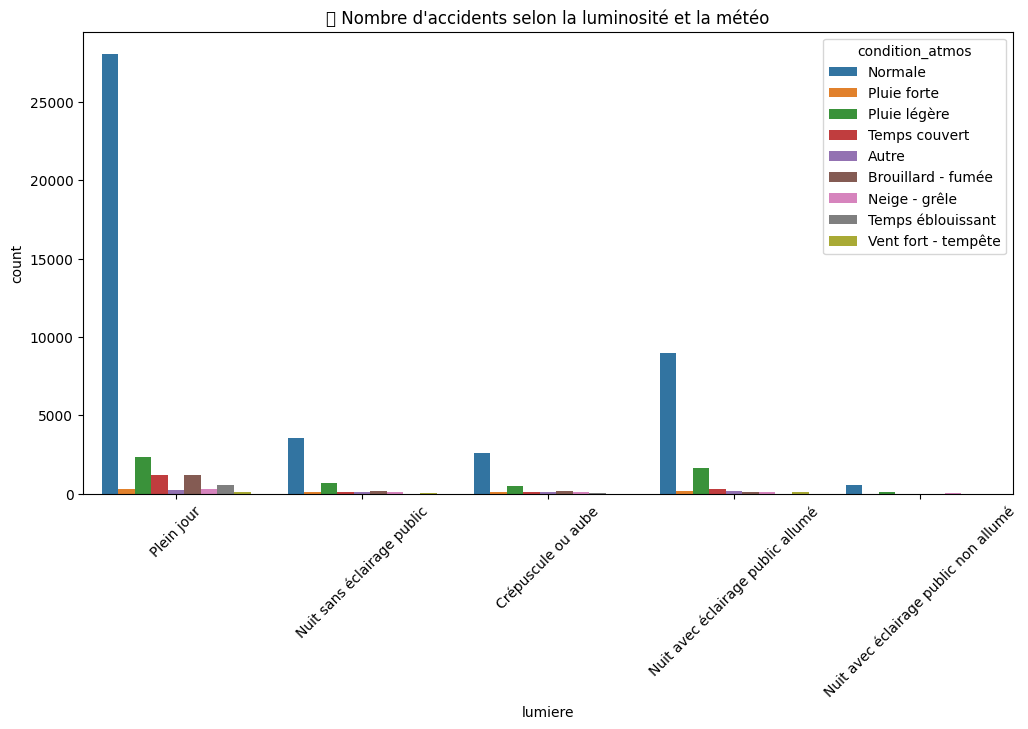

In [144]:
plt.figure(figsize=(12,6))
sns.countplot(data=df_full, x="lumiere", hue="condition_atmos")
plt.title("🌤️ Nombre d'accidents selon la luminosité et la météo")
plt.xticks(rotation=45)
plt.show()


In [206]:
top_depts = (
    df_full["nom_departement"]
    .value_counts()
    .head(10)
    .sort_values(ascending=True)
)

top_depts.plot(kind="barh", figsize=(10,6), color="tomato")
plt.title("🏙️ Top 10 départements les plus accidentogènes")
plt.xlabel("Nombre d'accidents")
plt.show()


KeyError: 'nom_departement'

In [204]:
plt.figure(figsize=(10,5))
sns.countplot(data=df_full, x="sexe", hue="gravite_accident")
plt.title("Gravité des accidents selon le sexe")
plt.xlabel("Sexe")
plt.ylabel("Nombre d'accidents")
plt.show()

plt.figure(figsize=(12,5))
sns.countplot(data=df_full, x="categorie_usager", hue="gravite_accident")
plt.title("Gravité selon la catégorie d'usager")
plt.xticks(rotation=45)
plt.show()


ValueError: Could not interpret value `sexe` for `x`. An entry with this name does not appear in `data`.

<Figure size 1000x500 with 0 Axes>

/Users/dahanifernando/Simplon/brief-analyse-traffic/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


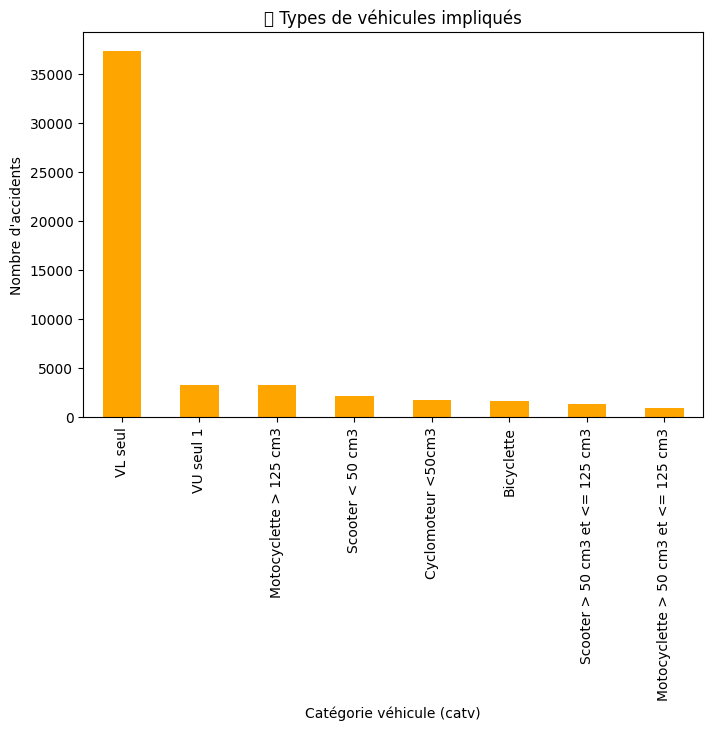

In [147]:
df_full['catv'].value_counts().head(8).plot(kind='bar', color='orange', figsize=(8,5))
plt.title("🚗 Types de véhicules impliqués")
plt.xlabel("Catégorie véhicule (catv)")
plt.ylabel("Nombre d'accidents")
plt.show()


/Users/dahanifernando/Simplon/brief-analyse-traffic/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


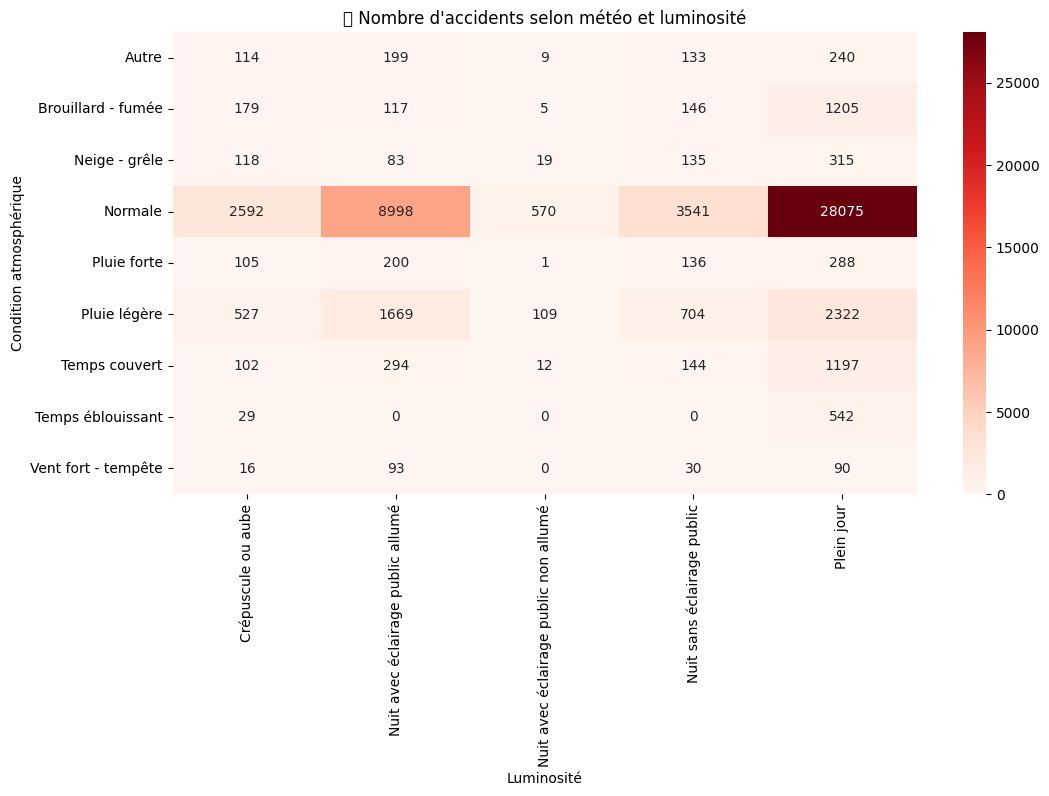

In [148]:
risk = (
    df_full.groupby(["condition_atmos", "lumiere"])
    .size()
    .reset_index(name="nb_accidents")
)

pivot = risk.pivot(index="condition_atmos", columns="lumiere", values="nb_accidents").fillna(0)

plt.figure(figsize=(12,6))
sns.heatmap(pivot, annot=True, cmap="Reds", fmt=".0f")
plt.title("🔥 Nombre d'accidents selon météo et luminosité")
plt.xlabel("Luminosité")
plt.ylabel("Condition atmosphérique")
plt.show()


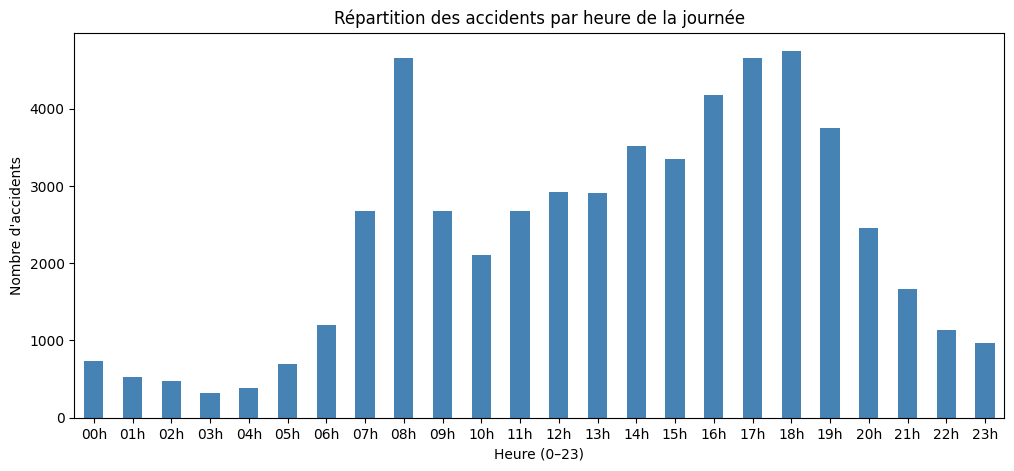

In [183]:
# Extraction propre de l'heure à partir de la colonne hrmn
# (elle peut être sous forme "HH:MM" ou "HHMM" ou "8h30")
df_full["heure"] = (
    df_full["hrmn"]
    .astype(str)
    .str.extract(r"(\d{1,2})")  # extrait les 1 ou 2 premiers chiffres
    .astype(float)
    .fillna(0)
    .astype(int)
)

# Compter le nombre d'accidents par heure
accidents_par_heure = (
    df_full["heure"]
    .value_counts()
    .reindex(range(24), fill_value=0)  # garantit les 24 heures
    .sort_index()
)

# Visualisation
plt.figure(figsize=(12,5))
accidents_par_heure.plot(kind="bar", color="steelblue")
plt.title("Répartition des accidents par heure de la journée")
plt.xlabel("Heure (0–23)")
plt.ylabel("Nombre d'accidents")
plt.xticks(range(24), labels=[f"{h:02d}h" for h in range(24)], rotation=0)
plt.show()


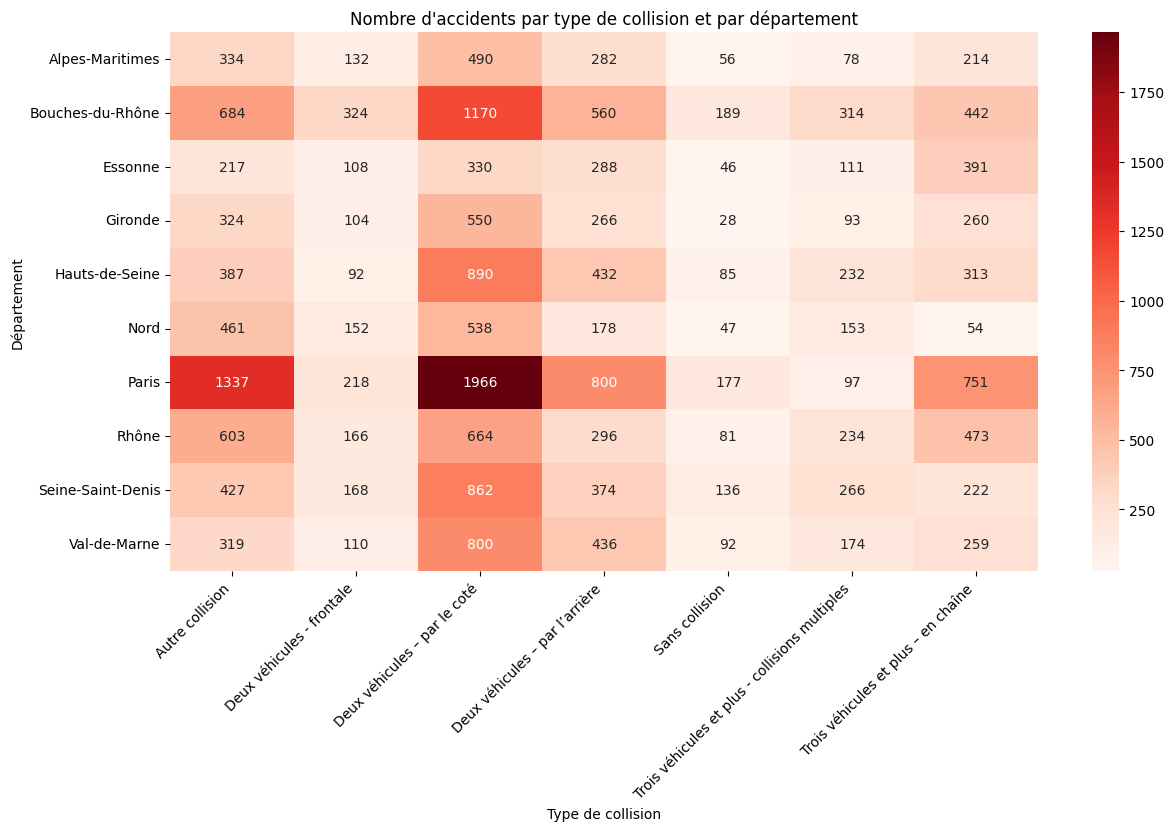

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt

# Comptage des accidents par département et type de collision
collision_stats = (
    df_full.groupby(["nom_departement", "collision"])
    .size()
    .reset_index(name="nb_accidents")
)

# Création du tableau croisé pour la heatmap
pivot = (
    collision_stats
    .pivot(index="nom_departement", columns="collision", values="nb_accidents")
    .fillna(0)
)

# Limiter aux 10 départements les plus accidentogènes (facilite la lecture)
top_depts = (
    df_full["nom_departement"].value_counts().head(10).index
)
pivot = pivot.loc[pivot.index.intersection(top_depts)]

# Visualisation
plt.figure(figsize=(14,7))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="Reds")
plt.title("Nombre d'accidents par type de collision et par département")
plt.xlabel("Type de collision")
plt.ylabel("Département")
plt.xticks(rotation=45, ha="right")
plt.show()


# dim contexxte

In [ ]:
query = """
SELECT 
    f.id_accident,
    c.lumiere,
    c.condition_atmos,
    c.collision,
    c.categorie_route,
    c.infrastructure,
    c.situation_accident,
    c.nombre_voie_circulation
FROM fact_accidents f
JOIN dim_contexte c ON f.id_contexte = c.id_contexte
"""
df_context = pd.read_sql_query(query, conn)
df_context.head()


,id_accident,lumiere,condition_atmos,collision,categorie_route,infrastructure,situation_accident,nombre_voie_circulation
0,201200031426,Plein jour,Normale,Autre collision,Voie Communale,None,Sur chaussée,3.0
1,201200033130,Plein jour,Normale,Autre collision,Voie Communale,None,Sur chaussée,2.0
2,201200037132,Nuit sans éclairage public,Normale,Deux véhicules – par l’arrière,Route Départementale,None,Sur chaussée,1.0
3,201200023044,Nuit sans éclairage public,Normale,Autre collision,Autoroute,None,Sur chaussée,2.0
4,201200030026,Plein jour,Normale,Deux véhicules - frontale,Voie Communale,Carrefour aménagé,None,2.0


## dataviz

/Users/dahanifernando/Simplon/brief-analyse-traffic/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128165 (\N{COLLISION SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


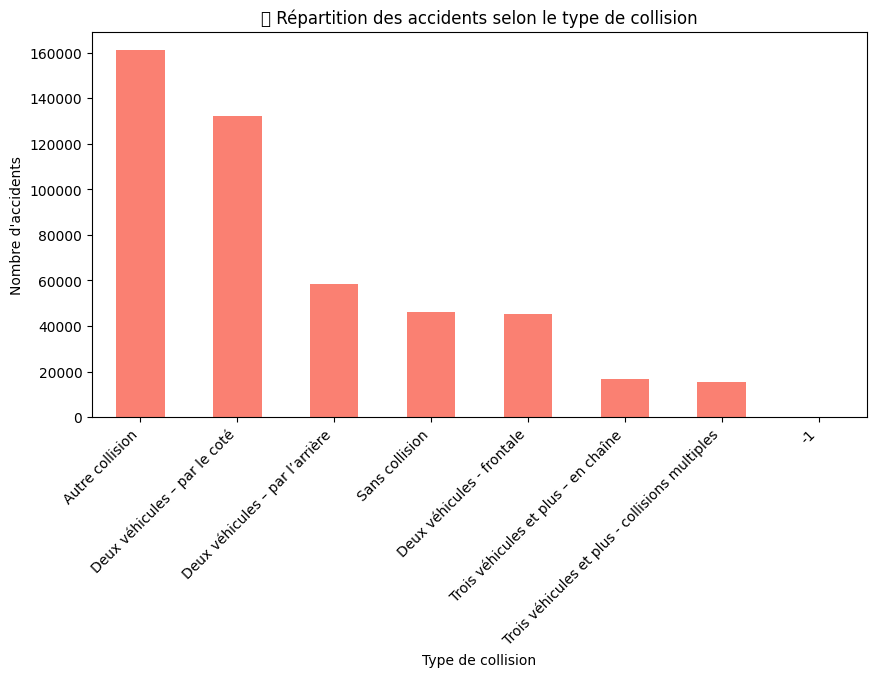

In [ ]:
plt.figure(figsize=(10,5))
df_context["collision"].value_counts().head(10).plot(kind="bar", color="salmon")
plt.title("💥 Répartition des accidents selon le type de collision")
plt.xlabel("Type de collision")
plt.ylabel("Nombre d'accidents")
plt.xticks(rotation=45, ha="right")
plt.show()


/Users/dahanifernando/Simplon/brief-analyse-traffic/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127782 (\N{WHITE SUN BEHIND CLOUD WITH RAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


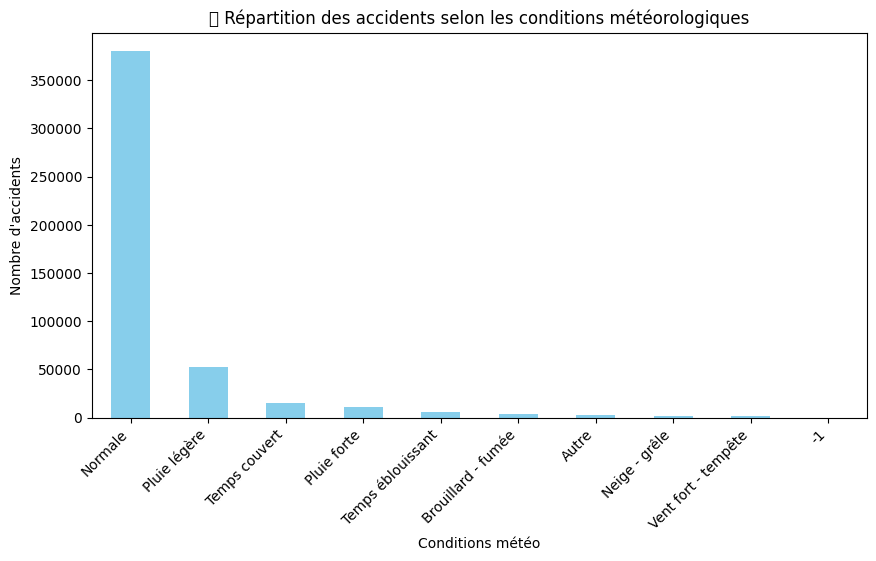

In [ ]:
plt.figure(figsize=(10,5))
df_context["condition_atmos"].value_counts().plot(kind="bar", color="skyblue")
plt.title("🌦️ Répartition des accidents selon les conditions météorologiques")
plt.xlabel("Conditions météo")
plt.ylabel("Nombre d'accidents")
plt.xticks(rotation=45, ha="right")
plt.show()


/var/folders/f7/x2q7zyyn1md5k9447n0knbrc0000gn/T/ipykernel_1561/2520581642.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_context, y="lumiere", order=df_context["lumiere"].value_counts().index, palette="mako")
/Users/dahanifernando/Simplon/brief-analyse-traffic/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


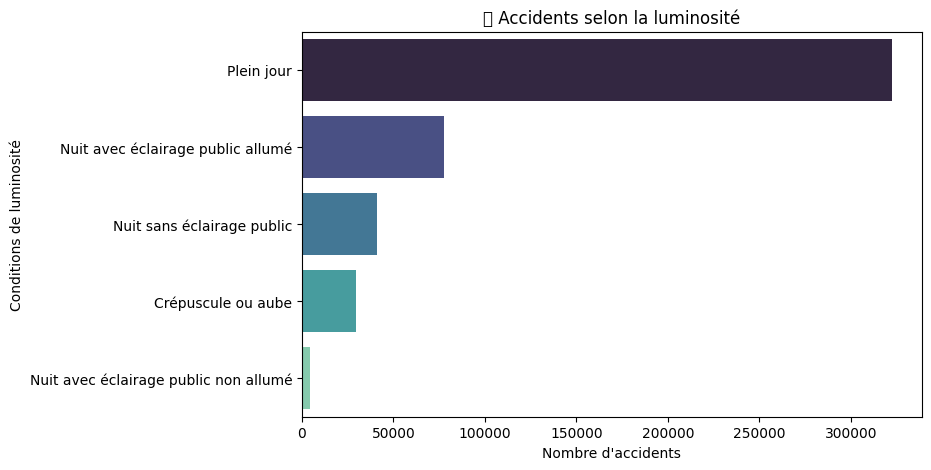

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(data=df_context, y="lumiere", order=df_context["lumiere"].value_counts().index, palette="mako")
plt.title("💡 Accidents selon la luminosité")
plt.xlabel("Nombre d'accidents")
plt.ylabel("Conditions de luminosité")
plt.show()


/var/folders/f7/x2q7zyyn1md5k9447n0knbrc0000gn/T/ipykernel_1561/3543265821.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_context, y="categorie_route", order=df_context["categorie_route"].value_counts().index[:10], palette="coolwarm")
/Users/dahanifernando/Simplon/brief-analyse-traffic/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128739 (\N{MOTORWAY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


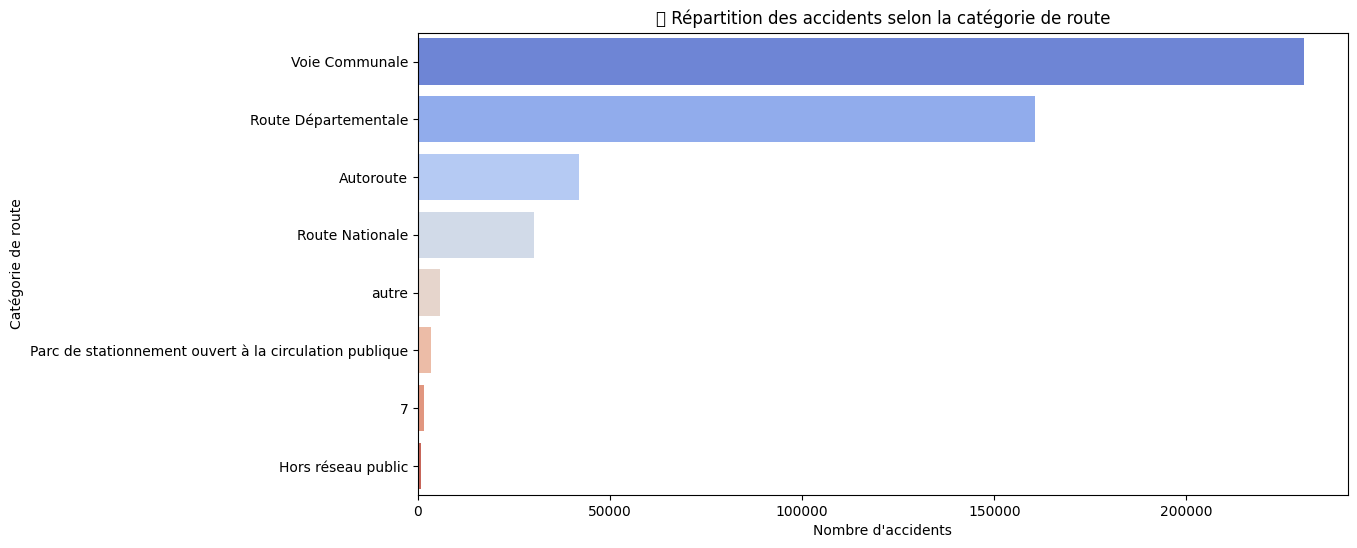

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(data=df_context, y="categorie_route", order=df_context["categorie_route"].value_counts().index[:10], palette="coolwarm")
plt.title("🛣️ Répartition des accidents selon la catégorie de route")
plt.xlabel("Nombre d'accidents")
plt.ylabel("Catégorie de route")
plt.show()


/Users/dahanifernando/Simplon/brief-analyse-traffic/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128679 (\N{CONSTRUCTION SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


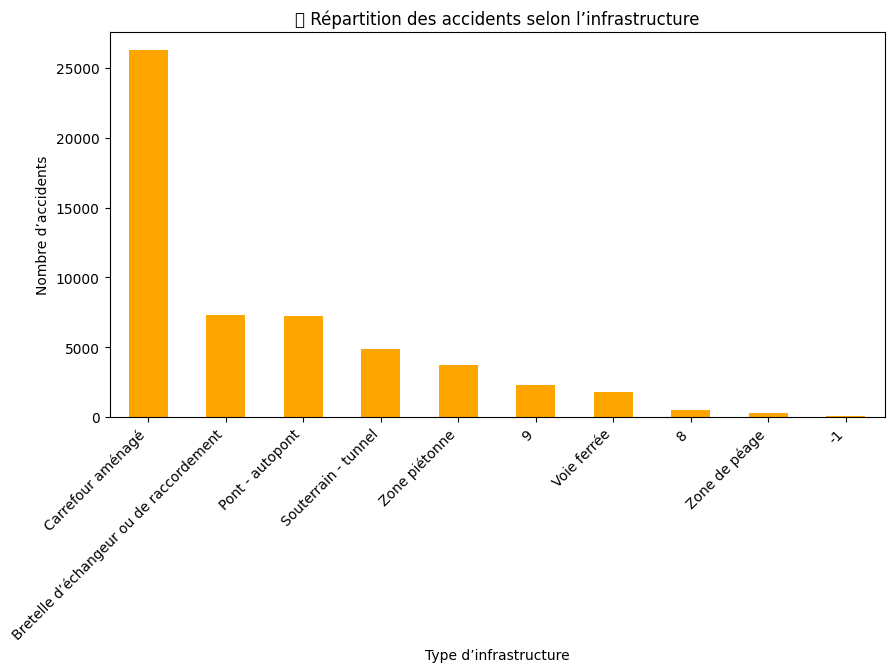

In [ ]:
plt.figure(figsize=(10,5))
df_context["infrastructure"].value_counts().head(10).plot(kind="bar", color="orange")
plt.title("🚧 Répartition des accidents selon l’infrastructure")
plt.xlabel("Type d’infrastructure")
plt.ylabel("Nombre d’accidents")
plt.xticks(rotation=45, ha="right")
plt.show()


/Users/dahanifernando/Simplon/brief-analyse-traffic/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


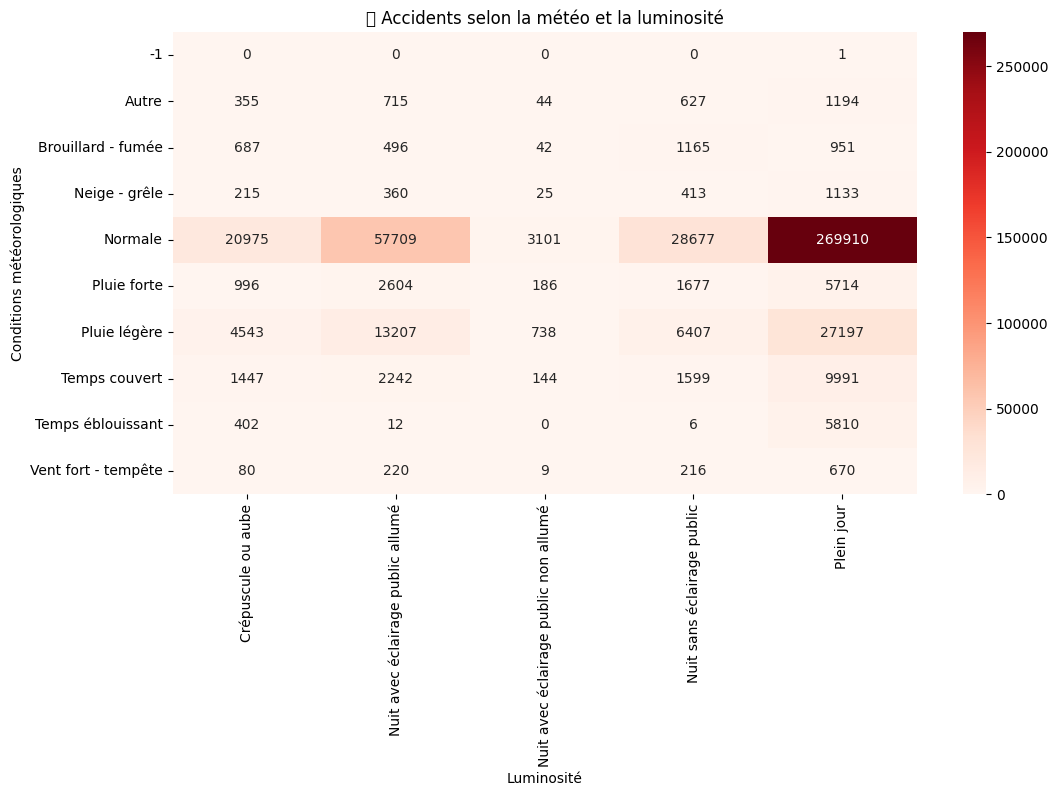

In [ ]:
heat = (
    df_context.groupby(["condition_atmos", "lumiere"])
    .size()
    .reset_index(name="nb_accidents")
)

pivot = heat.pivot(index="condition_atmos", columns="lumiere", values="nb_accidents").fillna(0)

plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap="Reds", annot=True, fmt=".0f")
plt.title("🔥 Accidents selon la météo et la luminosité")
plt.xlabel("Luminosité")
plt.ylabel("Conditions météorologiques")
plt.show()


/Users/dahanifernando/Simplon/brief-analyse-traffic/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


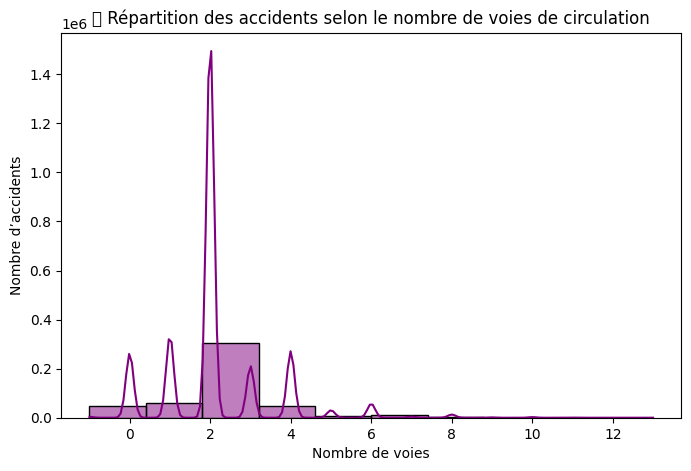

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df_context["nombre_voie_circulation"], bins=10, kde=True, color="purple")
plt.title("🚗 Répartition des accidents selon le nombre de voies de circulation")
plt.xlabel("Nombre de voies")
plt.ylabel("Nombre d’accidents")
plt.show()


/Users/dahanifernando/Simplon/brief-analyse-traffic/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127780 (\N{WHITE SUN WITH SMALL CLOUD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


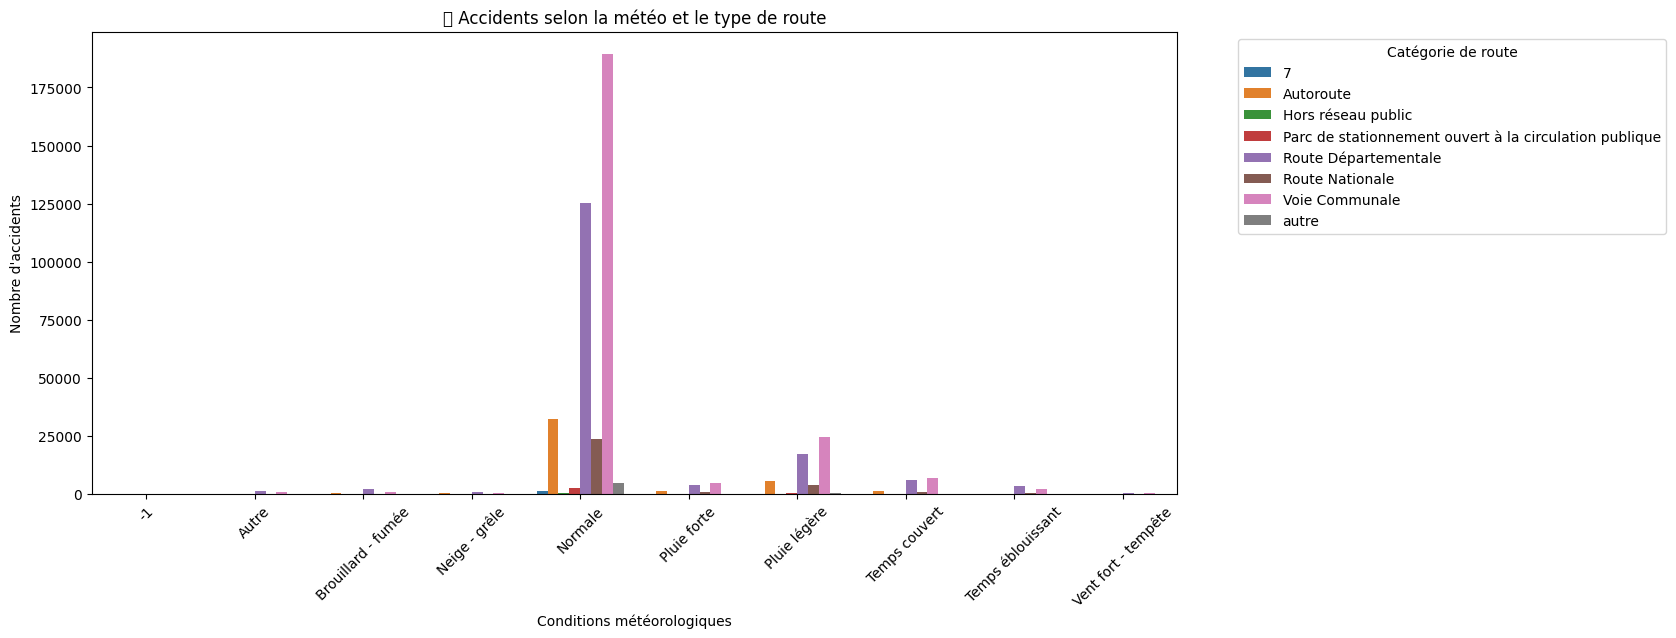

In [ ]:
cross = (
    df_context.groupby(["condition_atmos", "categorie_route"])
    .size()
    .reset_index(name="nb_accidents")
)

plt.figure(figsize=(14,6))
sns.barplot(data=cross, x="condition_atmos", y="nb_accidents", hue="categorie_route", palette="tab10")
plt.title("🌤️ Accidents selon la météo et le type de route")
plt.xlabel("Conditions météorologiques")
plt.ylabel("Nombre d'accidents")
plt.legend(title="Catégorie de route", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=45)
plt.show()


## v2

In [ ]:
query = """
SELECT 
    f.id_accident,
    c.lumiere,
    c.condition_atmos,
    c.collision,
    c.categorie_route,
    c.infrastructure,
    c.situation_accident,
    c.nombre_voie_circulation
FROM fact_accidents f
JOIN dim_contexte c ON f.id_contexte = c.id_contexte
"""
df_context = pd.read_sql_query(query, conn)
df_context.head()


,id_accident,lumiere,condition_atmos,collision,categorie_route,infrastructure,situation_accident,nombre_voie_circulation
0,201200031426,Plein jour,Normale,Autre collision,Voie Communale,None,Sur chaussée,3.0
1,201200033130,Plein jour,Normale,Autre collision,Voie Communale,None,Sur chaussée,2.0
2,201200037132,Nuit sans éclairage public,Normale,Deux véhicules – par l’arrière,Route Départementale,None,Sur chaussée,1.0
3,201200023044,Nuit sans éclairage public,Normale,Autre collision,Autoroute,None,Sur chaussée,2.0
4,201200030026,Plein jour,Normale,Deux véhicules - frontale,Voie Communale,Carrefour aménagé,None,2.0


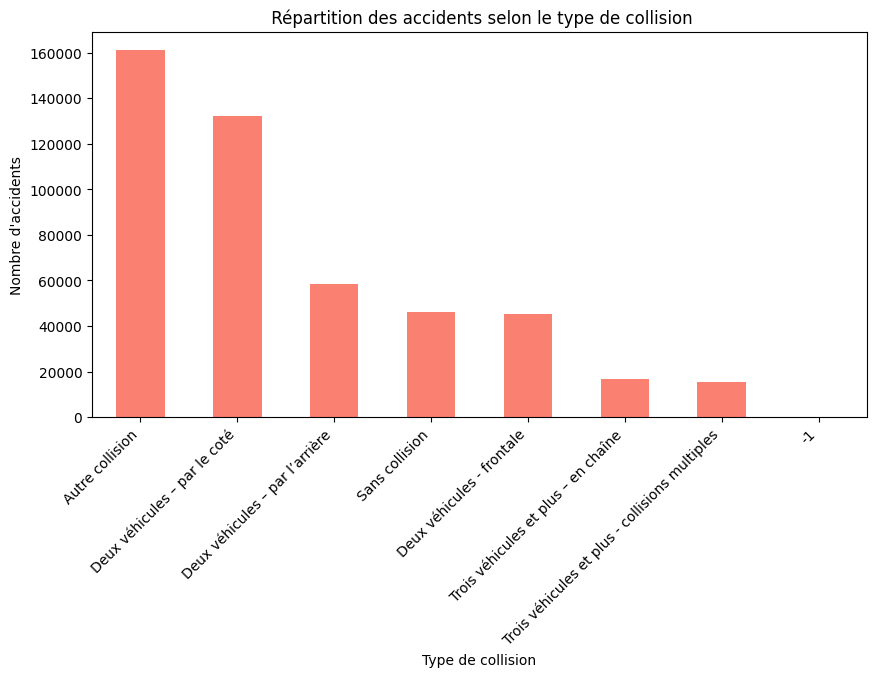

In [203]:
plt.figure(figsize=(10,5))
df_context["collision"].value_counts().head(10).plot(kind="bar", color="salmon")
plt.title(" Répartition des accidents selon le type de collision")
plt.xlabel("Type de collision")
plt.ylabel("Nombre d'accidents")
plt.xticks(rotation=45, ha="right")
plt.show()


/Users/dahanifernando/Simplon/brief-analyse-traffic/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127782 (\N{WHITE SUN BEHIND CLOUD WITH RAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


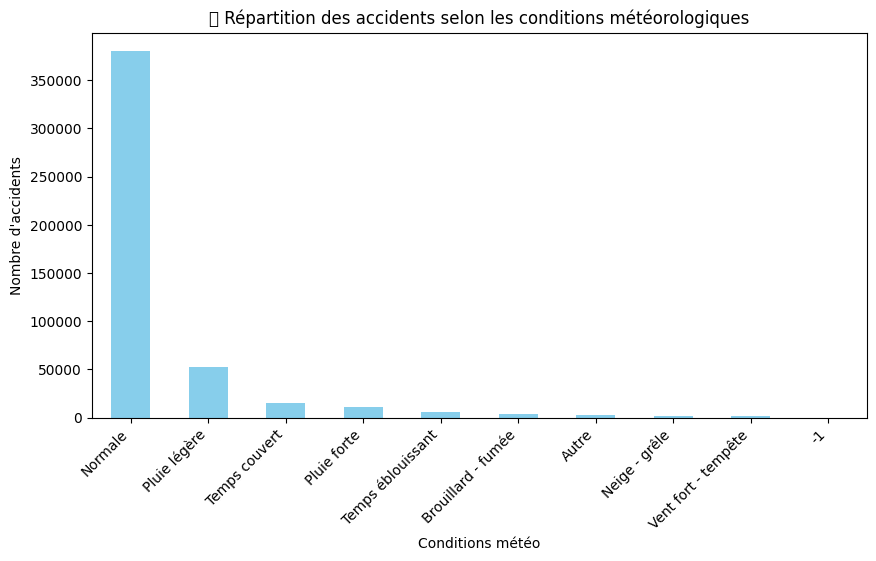

In [ ]:
plt.figure(figsize=(10,5))
df_context["condition_atmos"].value_counts().plot(kind="bar", color="skyblue")
plt.title("🌦️ Répartition des accidents selon les conditions météorologiques")
plt.xlabel("Conditions météo")
plt.ylabel("Nombre d'accidents")
plt.xticks(rotation=45, ha="right")
plt.show()


/var/folders/f7/x2q7zyyn1md5k9447n0knbrc0000gn/T/ipykernel_1561/2520581642.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_context, y="lumiere", order=df_context["lumiere"].value_counts().index, palette="mako")
/Users/dahanifernando/Simplon/brief-analyse-traffic/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128161 (\N{ELECTRIC LIGHT BULB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


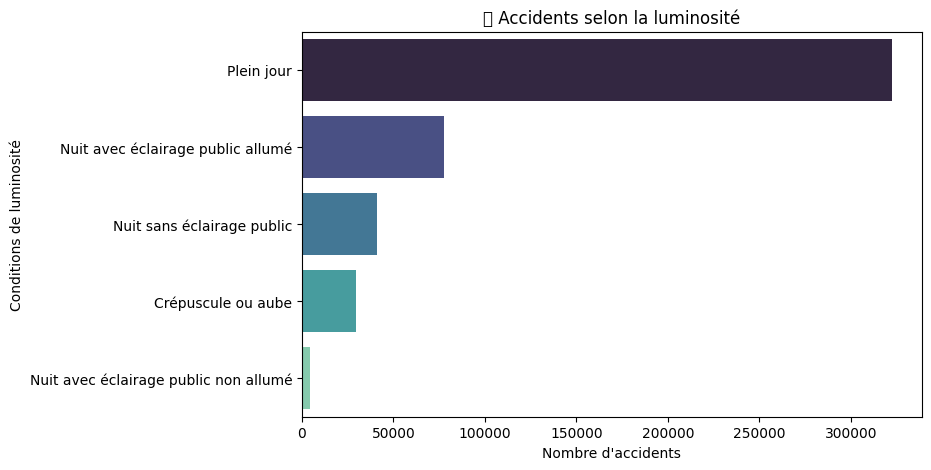

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(data=df_context, y="lumiere", order=df_context["lumiere"].value_counts().index, palette="mako")
plt.title("💡 Accidents selon la luminosité")
plt.xlabel("Nombre d'accidents")
plt.ylabel("Conditions de luminosité")
plt.show()


/var/folders/f7/x2q7zyyn1md5k9447n0knbrc0000gn/T/ipykernel_1561/3543265821.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_context, y="categorie_route", order=df_context["categorie_route"].value_counts().index[:10], palette="coolwarm")
/Users/dahanifernando/Simplon/brief-analyse-traffic/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128739 (\N{MOTORWAY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


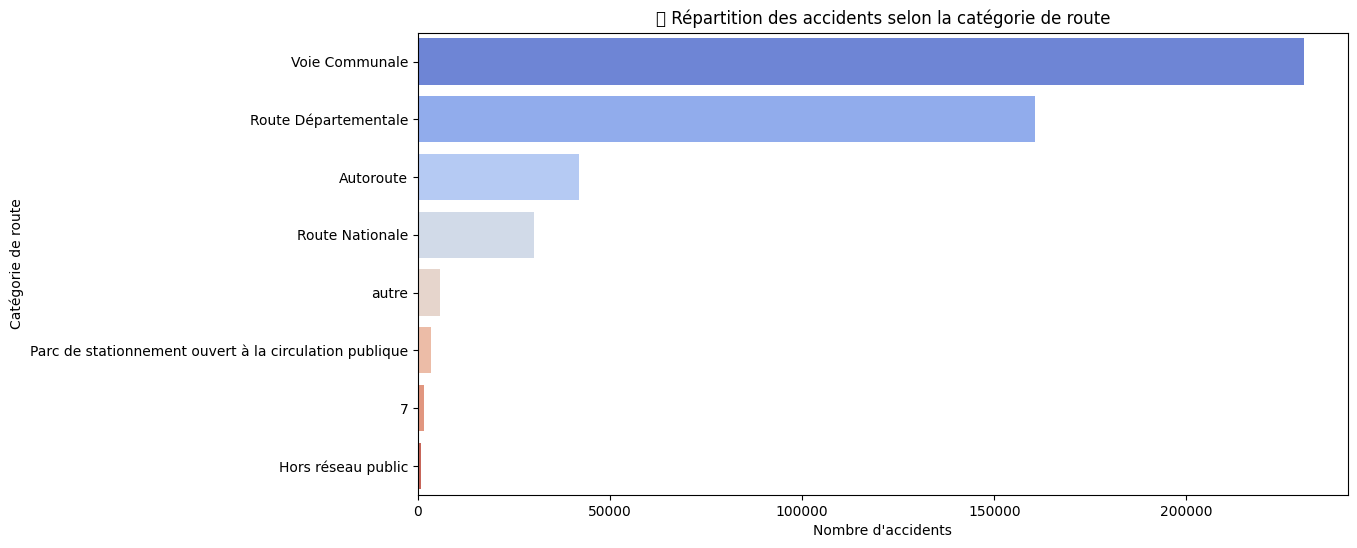

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(data=df_context, y="categorie_route", order=df_context["categorie_route"].value_counts().index[:10], palette="coolwarm")
plt.title("🛣️ Répartition des accidents selon la catégorie de route")
plt.xlabel("Nombre d'accidents")
plt.ylabel("Catégorie de route")
plt.show()


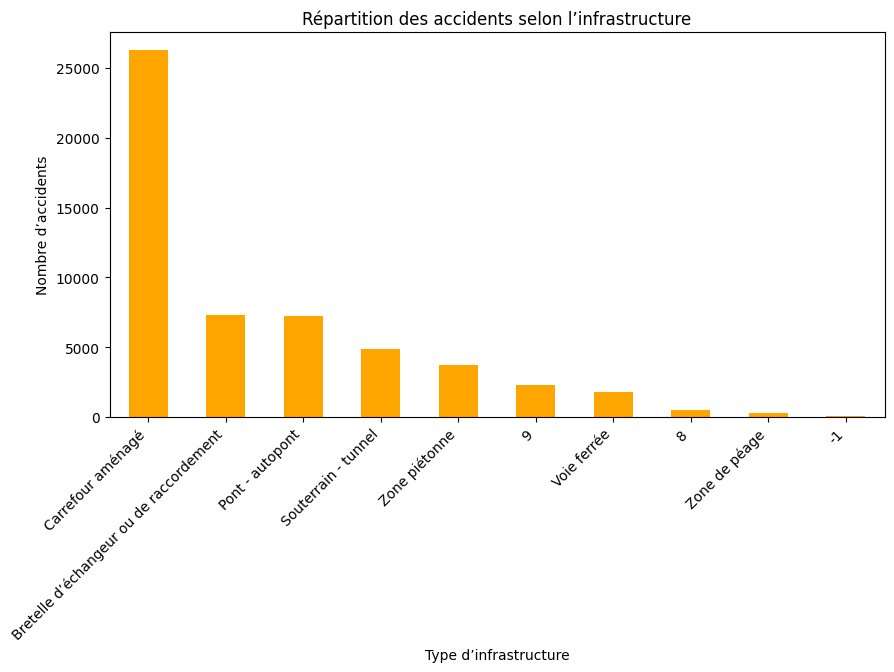

In [186]:
df_contexte["infrastructure"] = df_contexte["infrastructure"].replace({"8": "Zone de péage", "9": "Voie ferrée", "-1": "Inconnu"})
plt.figure(figsize=(10,5))
df_context["infrastructure"].value_counts().head(10).plot(kind="bar", color="orange")
plt.title("Répartition des accidents selon l’infrastructure")
plt.xlabel("Type d’infrastructure")
plt.ylabel("Nombre d’accidents")
plt.xticks(rotation=45, ha="right")
plt.show()


/Users/dahanifernando/Simplon/brief-analyse-traffic/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


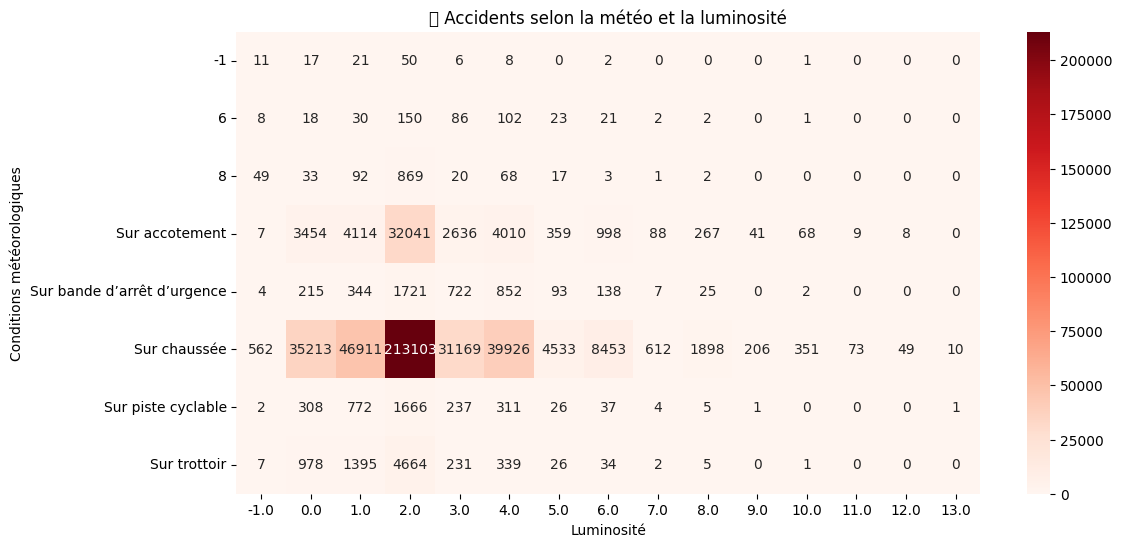

In [ ]:
heat = (
    df_context.groupby(["situation_accident", "nombre_voie_circulation"])
    .size()
    .reset_index(name="nb_accidents")
)

pivot = heat.pivot(index="situation_accident", columns="nombre_voie_circulation", values="nb_accidents").fillna(0)

plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap="Reds", annot=True, fmt=".0f")
plt.title("🔥 Accidents selon la météo et la luminosité")
plt.xlabel("Luminosité")
plt.ylabel("Conditions météorologiques")
plt.show()


In [156]:
query = """
SELECT place, gravite_accident
FROM dim_usager
WHERE place IS NOT NULL
"""
df_usagers = pd.read_sql_query(query, conn)

In [157]:
# Nettoyage de la colonne "place"
df_usagers["place"] = (
    df_usagers["place"]
    .astype(str)
    .str.replace(r"[\[\]']", "", regex=True)  # retire les crochets et guillemets
    .str.split(",")                           # coupe les éventuelles listes
    .str[0]                                   # garde seulement la première valeur
    .str.strip()                              # retire les espaces
    .str.lower()                              # met tout en minuscule
)

/var/folders/f7/x2q7zyyn1md5k9447n0knbrc0000gn/T/ipykernel_1561/493609280.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


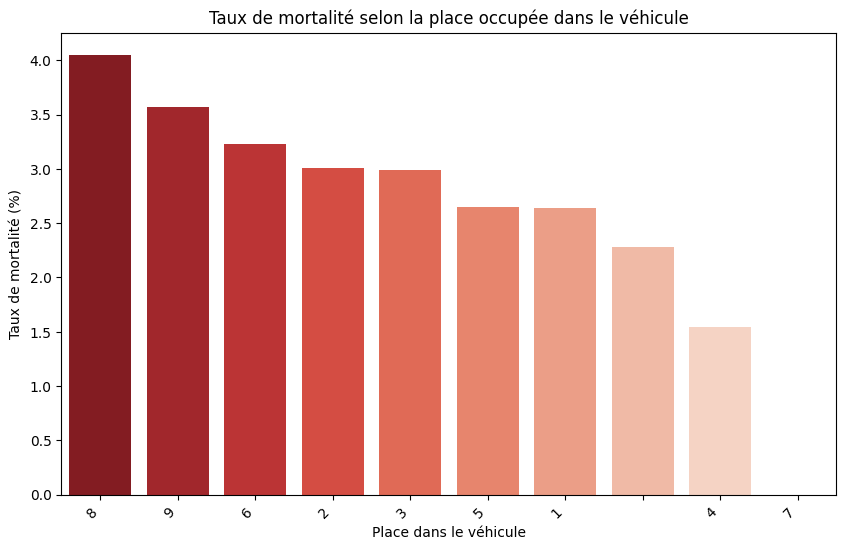

In [164]:
totaux = df_usagers.groupby("place").size().rename("total")

morts = (
    df_usagers[df_usagers["gravite_accident"].str.contains("tué", na=False)]
    .groupby("place")
    .size()
    .rename("nb_tues")
)

stats_places = (
    pd.concat([totaux, morts], axis=1)
    .fillna(0)
    .assign(taux_mortalite=lambda d: d["nb_tues"] / d["total"] * 100)
    .sort_values("taux_mortalite", ascending=False)
)

plt.figure(figsize=(10,6))
sns.barplot(
    data=stats_places.reset_index(),
    x="place",
    y="taux_mortalite",
    palette="Reds_r"
)
plt.title("Taux de mortalité selon la place occupée dans le véhicule")
plt.xlabel("Place dans le véhicule")
plt.ylabel("Taux de mortalité (%)")
plt.xticks(rotation=45, ha="right")
plt.show()

In [159]:
# Normalisation du texte (tout en minuscule)
df_usagers["place"] = df_usagers["place"].str.lower()
df_usagers["gravite_accident"] = df_usagers["gravite_accident"].str.lower()

# Comptage total par place
totaux = df_usagers.groupby("place").size().rename("total")

# Comptage des morts par place
morts = (
    df_usagers[df_usagers["gravite_accident"].str.contains("tué", na=False)]
    .groupby("place")
    .size()
    .rename("nb_tues")
)

# Fusion et calcul du taux
stats_places = (
    pd.concat([totaux, morts], axis=1)
    .fillna(0)
    .assign(taux_mortalite=lambda d: d["nb_tues"] / d["total"] * 100)
    .sort_values("taux_mortalite", ascending=False)
)

display(stats_places)

,total,nb_tues,taux_mortalite
place,,,
8,74,3.0,4.054054
9,28,1.0,3.571429
6,31,1.0,3.225806
2,2962,89.0,3.004727
3,636,19.0,2.987421
5,302,8.0,2.649007
1,24601,649.0,2.638104
,219,5.0,2.283105
4,583,9.0,1.543739


/var/folders/f7/x2q7zyyn1md5k9447n0knbrc0000gn/T/ipykernel_1561/1842372174.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


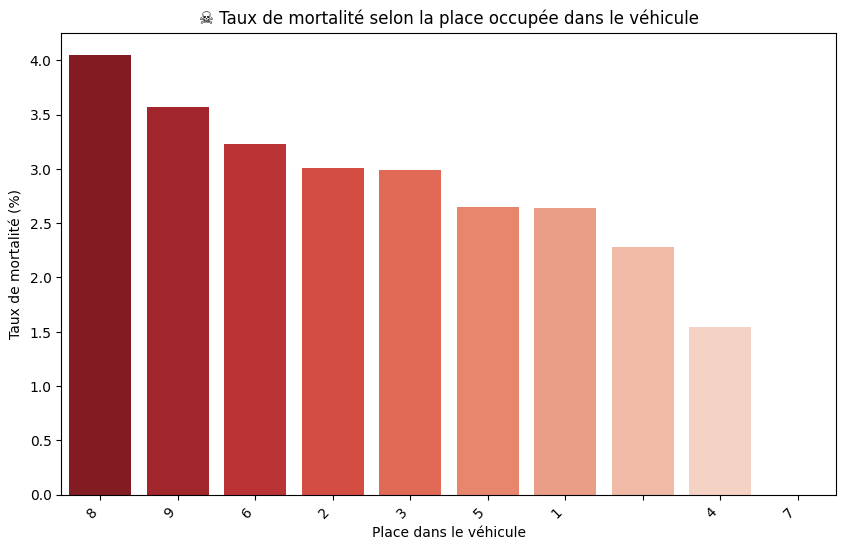

In [160]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=stats_places.reset_index(),
    x="place",
    y="taux_mortalite",
    palette="Reds_r"
)
plt.title("☠️ Taux de mortalité selon la place occupée dans le véhicule")
plt.xlabel("Place dans le véhicule")
plt.ylabel("Taux de mortalité (%)")
plt.xticks(rotation=45, ha="right")
plt.show()

 Taux de mortalité calculé par place :


,total,nb_tues,taux_mortalite
place_label,,,
Inconnu,74,3.0,4.054054
Autre,28,1.0,3.571429
Autre rang,31,1.0,3.225806
Passager avant,2962,89.0,3.004727
Arrière gauche,636,19.0,2.987421
Arrière droit,302,8.0,2.649007
Conducteur,24601,649.0,2.638104
Arrière milieu,583,9.0,1.543739
Extérieur,33,0.0,0.000000


/var/folders/f7/x2q7zyyn1md5k9447n0knbrc0000gn/T/ipykernel_1561/4138035380.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


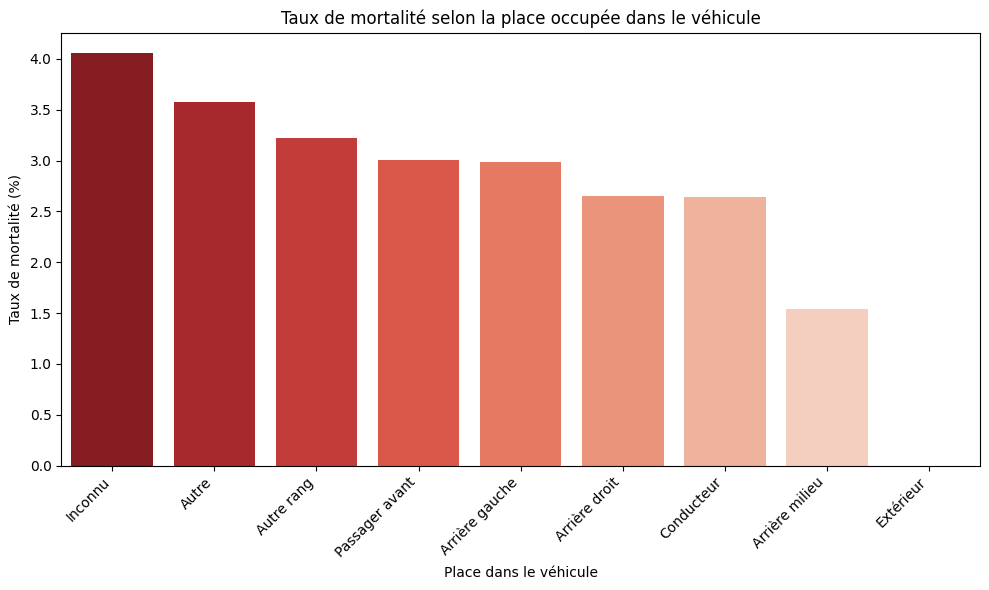

In [165]:

place_mapping = {
    1: "Conducteur",
    2: "Passager avant",
    3: "Arrière gauche",
    4: "Arrière milieu",
    5: "Arrière droit",
    6: "Autre rang",
    7: "Extérieur",
    8: "Inconnu",
    9: "Autre"
}

# Vérification du type et conversion si besoin
df_usagers["place"] = pd.to_numeric(df_usagers["place"], errors="coerce")

# Ajout de la colonne texte lisible
df_usagers["place_label"] = df_usagers["place"].map(place_mapping)



# Total des usagers par place
totaux = df_usagers.groupby("place_label").size().rename("total")

# Nombre de tués par place (filtrage sur "gravite_accident")
morts = (
    df_usagers[df_usagers["gravite_accident"].str.contains("tué", case=False, na=False)]
    .groupby("place_label")
    .size()
    .rename("nb_tues")
)

# Fusion et calcul du taux de mortalité
stats_places = (
    pd.concat([totaux, morts], axis=1)
    .fillna(0)
    .assign(taux_mortalite=lambda d: d["nb_tues"] / d["total"] * 100)
    .sort_values("taux_mortalite", ascending=False)
)

print(" Taux de mortalité calculé par place :")
display(stats_places)


plt.figure(figsize=(10,6))
sns.barplot(
    data=stats_places.reset_index(),
    x="place_label",
    y="taux_mortalite",
    palette="Reds_r"
)
plt.title("Taux de mortalité selon la place occupée dans le véhicule")
plt.xlabel("Place dans le véhicule")
plt.ylabel("Taux de mortalité (%)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Valeurs uniques de la colonne 'securite' :
['Autre' 'Ceinture']


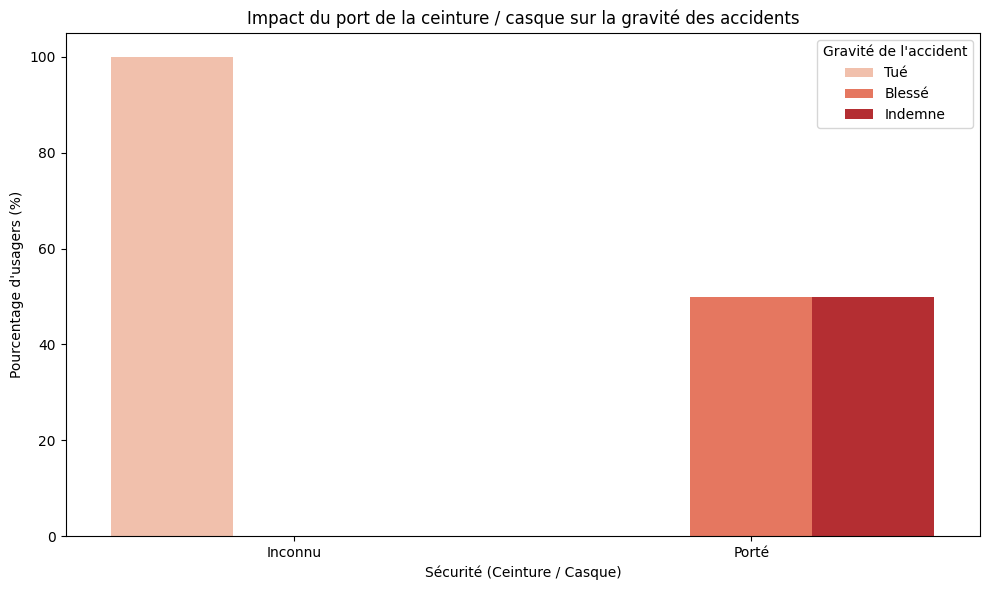

In [168]:
# Vérif rapide de la colonne 'securite'
print("Valeurs uniques de la colonne 'securite' :")
print(df_dim_usager["securite"].unique())

# --- Simplification des valeurs de sécurité ---
def simplifier_securite(val):
    if pd.isna(val):
        return "Inconnu"
    val = str(val).lower()
    if any(x in val for x in ["ceinture", "casque", "retenue", "airbag"]):
        return "Porté"
    elif any(x in val for x in ["non", "aucun", "abs", "sans"]):
        return "Non porté"
    else:
        return "Inconnu"

df_dim_usager["securite_simple"] = df_dim_usager["securite"].apply(simplifier_securite)

# --- Simplification de la gravité ---
def simplifier_gravite(val):
    if pd.isna(val):
        return "Inconnu"
    val = str(val).lower()
    if "tué" in val:
        return "Tué"
    elif "blessé" in val:
        return "Blessé"
    elif "indemne" in val:
        return "Indemne"
    else:
        return "Autre"

df_dim_usager["gravite_simple"] = df_dim_usager["gravite_accident"].apply(simplifier_gravite)

# --- Comptage croisé ---
pivot = (
    df_dim_usager
    .groupby(["securite_simple", "gravite_simple"])
    .size()
    .reset_index(name="nb_usagers")
)

# --- Calcul des pourcentages (fix de l’erreur d’index) ---
pivot["pct"] = pivot.groupby("securite_simple")["nb_usagers"].transform(lambda x: x / x.sum() * 100)

# --- Visualisation ---
plt.figure(figsize=(10,6))
sns.barplot(
    data=pivot,
    x="securite_simple",
    y="pct",
    hue="gravite_simple",
    palette="Reds"
)
plt.title("Impact du port de la ceinture / casque sur la gravité des accidents")
plt.xlabel("Sécurité (Ceinture / Casque)")
plt.ylabel("Pourcentage d'usagers (%)")
plt.legend(title="Gravité de l'accident")
plt.tight_layout()
plt.show()

In [172]:
sorted(df_dim_usager["securite"].dropna().unique())

['Autre', 'Ceinture']

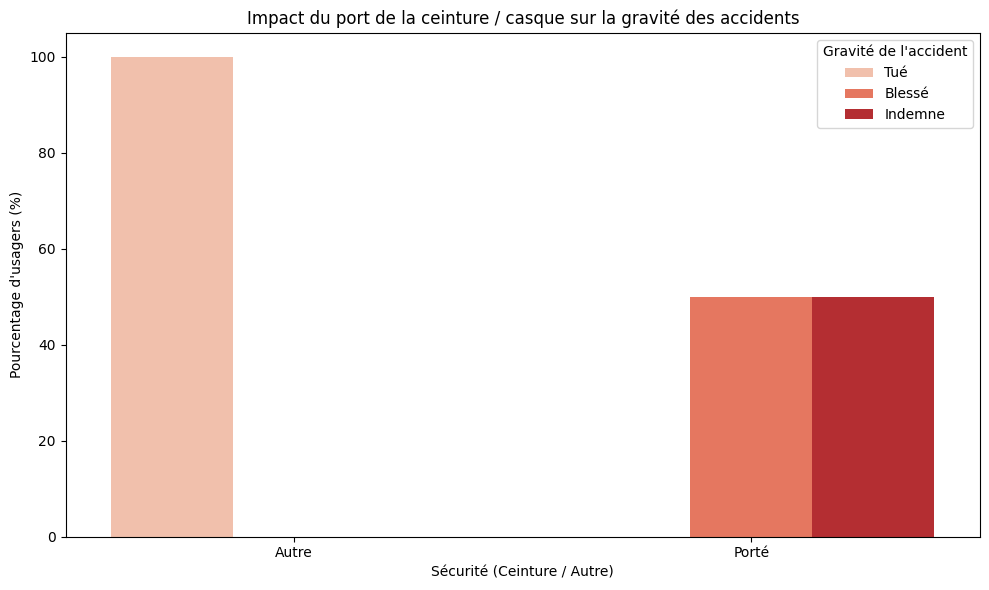

In [208]:


# Simplification adaptée à ton jeu de données
def simplifier_securite(val):
    if pd.isna(val):
        return "Inconnu"
    val = str(val).strip().lower()
    if "ceinture" in val or "casque" in val:
        return "Porté"
    elif "autre" in val:
        return "Autre"
    else:
        return "Inconnu"

df_dim_usager["securite_simple"] = df_dim_usager["securite"].apply(simplifier_securite)

# Simplification gravité
def simplifier_gravite(val):
    if pd.isna(val):
        return "Inconnu"
    val = str(val).lower()
    if "tué" in val:
        return "Tué"
    elif "bless" in val:
        return "Blessé"
    elif "indemne" in val:
        return "Indemne"
    else:
        return "Autre"

df_dim_usager["gravite_simple"] = df_dim_usager["gravite_accident"].apply(simplifier_gravite)

# Comptage et pourcentage
pivot = (
    df_dim_usager
    .groupby(["securite_simple", "gravite_simple"])
    .size()
    .reset_index(name="nb_usagers")
)
pivot["pct"] = pivot.groupby("securite_simple")["nb_usagers"].transform(lambda x: x / x.sum() * 100)

# Visualisation
plt.figure(figsize=(10,6))
sns.barplot(
    data=pivot,
    x="securite_simple",
    y="pct",
    hue="gravite_simple",
    palette="Reds"
)
plt.title("Impact du port de la ceinture / casque sur la gravité des accidents")
plt.xlabel("Sécurité (Ceinture / Autre)")
plt.ylabel("Pourcentage d'usagers (%)")
plt.legend(title="Gravité de l'accident")
plt.tight_layout()
plt.show()


Taux de mortalité (uniquement pour véhicules avec plusieurs usagers) :


/var/folders/f7/x2q7zyyn1md5k9447n0knbrc0000gn/T/ipykernel_1561/807513584.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_usagers_multi["place"] = pd.to_numeric(df_usagers_multi["place"], errors="coerce")
/var/folders/f7/x2q7zyyn1md5k9447n0knbrc0000gn/T/ipykernel_1561/807513584.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_usagers_multi["place_label"] = df_usagers_multi["place"].map(place_mapping)


,total,nb_tues,taux_mortalite
place_label,,,
Inconnu,74,3.0,4.054054
Autre,28,1.0,3.571429
Arrière gauche,634,19.0,2.996845
Passager avant,2899,86.0,2.966540
Arrière droit,299,8.0,2.675585
Conducteur,19737,396.0,2.006384
Arrière milieu,580,9.0,1.551724
Autre rang,30,0.0,0.000000
Extérieur,33,0.0,0.000000


/var/folders/f7/x2q7zyyn1md5k9447n0knbrc0000gn/T/ipykernel_1561/807513584.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


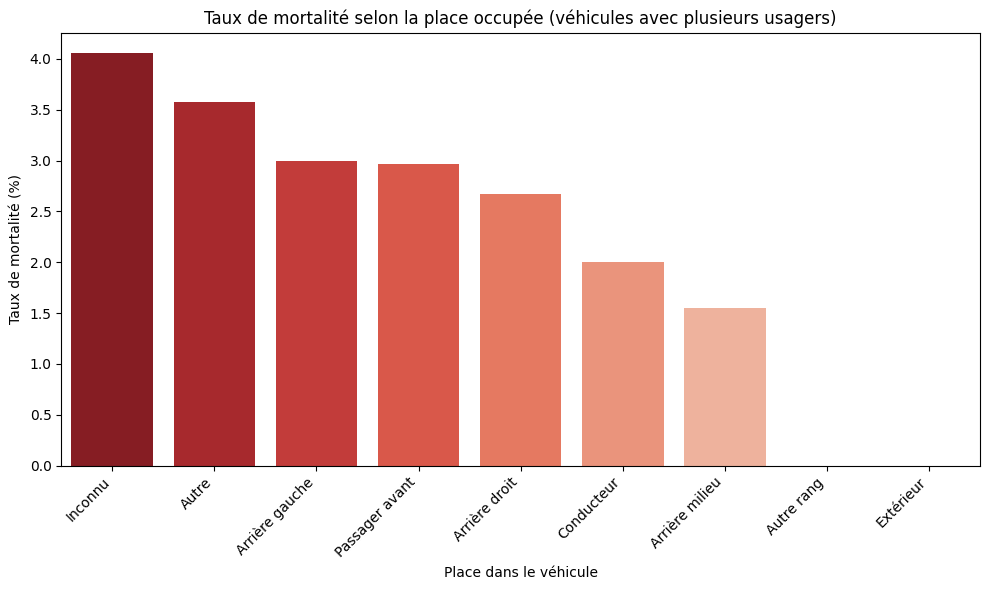

In [181]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1️⃣ Charger les tables nécessaires ---
df_usagers = pd.read_sql_query("SELECT * FROM dim_usager;", conn)
df_vehicules = pd.read_sql_query("SELECT * FROM dim_vehicule;", conn)

# --- 2️⃣ Déterminer les véhicules avec plusieurs usagers ---
# On compte combien d'usagers sont associés à chaque accident
usagers_par_accident = df_usagers.groupby("id_accident").size().reset_index(name="nb_usagers")

# On ne garde que les accidents où il y a plusieurs usagers
multi_usagers = usagers_par_accident[usagers_par_accident["nb_usagers"] > 1]["id_accident"]

# Filtrer df_usagers pour ne garder que ces cas
df_usagers_multi = df_usagers[df_usagers["id_accident"].isin(multi_usagers)]

# --- 3️⃣ Mapping des places ---
place_mapping = {
    1: "Conducteur",
    2: "Passager avant",
    3: "Arrière gauche",
    4: "Arrière milieu",
    5: "Arrière droit",
    6: "Autre rang",
    7: "Extérieur",
    8: "Inconnu",
    9: "Autre"
}

df_usagers_multi["place"] = pd.to_numeric(df_usagers_multi["place"], errors="coerce")
df_usagers_multi["place_label"] = df_usagers_multi["place"].map(place_mapping)

# --- 4️⃣ Calcul du taux de mortalité ---
totaux = df_usagers_multi.groupby("place_label").size().rename("total")

morts = (
    df_usagers_multi[df_usagers_multi["gravite_accident"].str.contains("tué", case=False, na=False)]
    .groupby("place_label")
    .size()
    .rename("nb_tues")
)

stats_places = (
    pd.concat([totaux, morts], axis=1)
    .fillna(0)
    .assign(taux_mortalite=lambda d: d["nb_tues"] / d["total"] * 100)
    .sort_values("taux_mortalite", ascending=False)
)

print("Taux de mortalité (uniquement pour véhicules avec plusieurs usagers) :")
display(stats_places)

# --- 5️⃣ Visualisation ---
plt.figure(figsize=(10,6))
sns.barplot(
    data=stats_places.reset_index(),
    x="place_label",
    y="taux_mortalite",
    palette="Reds_r"
)
plt.title("Taux de mortalité selon la place occupée (véhicules avec plusieurs usagers)")
plt.xlabel("Place dans le véhicule")
plt.ylabel("Taux de mortalité (%)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


/var/folders/f7/x2q7zyyn1md5k9447n0knbrc0000gn/T/ipykernel_1561/2540367906.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/f7/x2q7zyyn1md5k9447n0knbrc0000gn/T/ipykernel_1561/2540367906.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


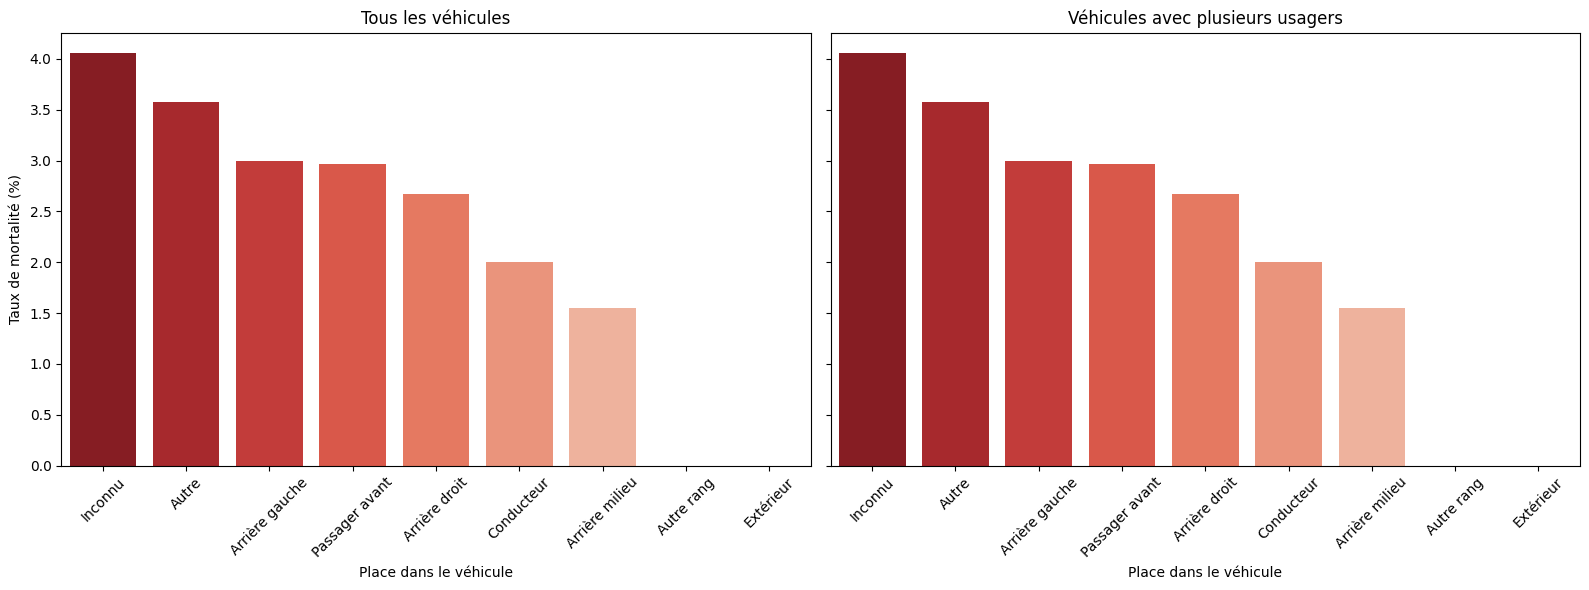

In [182]:
fig, axes = plt.subplots(1, 2, figsize=(16,6), sharey=True)

# Tous les usagers
sns.barplot(
    data=stats_places.reset_index(),
    x="place_label",
    y="taux_mortalite",
    palette="Reds_r",
    ax=axes[0]
)
axes[0].set_title("Tous les véhicules")

# Véhicules multi-usagers uniquement
totaux_multi = df_usagers_multi.groupby("place_label").size().rename("total")
morts_multi = (
    df_usagers_multi[df_usagers_multi["gravite_accident"].str.contains("tué", case=False, na=False)]
    .groupby("place_label")
    .size()
    .rename("nb_tues")
)
stats_multi = (
    pd.concat([totaux_multi, morts_multi], axis=1)
    .fillna(0)
    .assign(taux_mortalite=lambda d: d["nb_tues"] / d["total"] * 100)
    .sort_values("taux_mortalite", ascending=False)
)
sns.barplot(
    data=stats_multi.reset_index(),
    x="place_label",
    y="taux_mortalite",
    palette="Reds_r",
    ax=axes[1]
)
axes[1].set_title("Véhicules avec plusieurs usagers")

for ax in axes:
    ax.set_xlabel("Place dans le véhicule")
    ax.set_ylabel("Taux de mortalité (%)")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

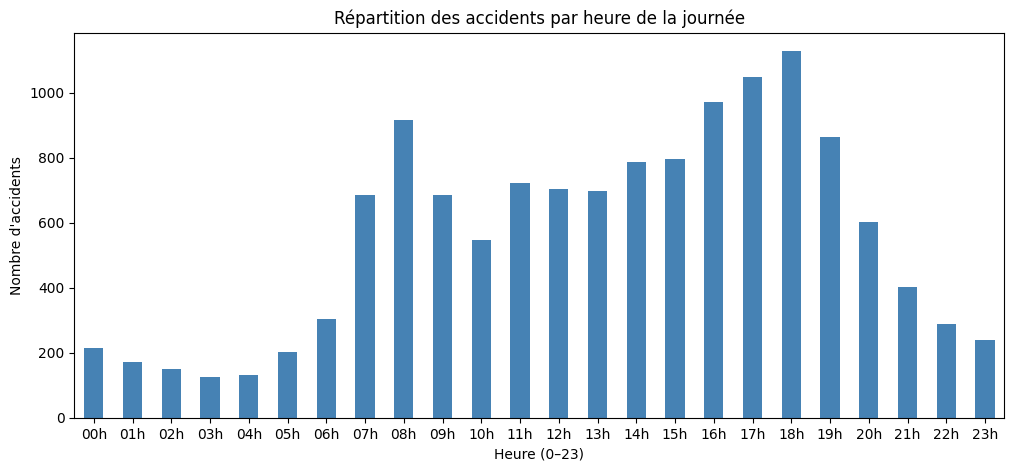

In [188]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

# Connexion à la base
conn = sqlite3.connect("../accidents.db")

# Récupération des tables nécessaires
df_temps = pd.read_sql_query("SELECT * FROM dim_temps;", conn)
df_accidents = pd.read_sql_query("SELECT * FROM fact_accidents;", conn)

# Jointure sur la date
df_full = df_accidents.merge(df_temps, on="id_date", how="left")

# Extraction de l’heure
df_full["heure"] = (
    df_full["hrmn"]
    .astype(str)
    .str.extract(r"(\d{1,2})")[0]
    .astype(float)
    .fillna(0)
    .astype(int)
)

# Comptage par heure
accidents_par_heure = (
    df_full["heure"]
    .value_counts()
    .reindex(range(24), fill_value=0)
    .sort_index()
)

# 📊 Visualisation
plt.figure(figsize=(12,5))
accidents_par_heure.plot(kind="bar", color="steelblue")
plt.title("Répartition des accidents par heure de la journée")
plt.xlabel("Heure (0–23)")
plt.ylabel("Nombre d'accidents")
plt.xticks(range(24), labels=[f"{h:02d}h" for h in range(24)], rotation=0)
plt.show()


In [194]:
print("Colonnes dans dim_contexte :", df_contexte.columns.tolist())
print(df_contexte.head())

Colonnes dans dim_contexte : ['id_contexte', 'lumiere', 'intersection', 'condition_atmos', 'collision', 'type_surface', 'regime_circulation', 'voie_reservee', 'proximite_ecole', 'nombre_voie_circulation', 'categorie_route', 'pente', 'infrastructure', 'situation_accident']
       id_contexte                     lumiere intersection condition_atmos  \
0  ctx201200031426                  Plein jour            1         Normale   
1  ctx201200033130                  Plein jour            1         Normale   
2  ctx201200037132  Nuit sans éclairage public            4         Normale   
3  ctx201200023044  Nuit sans éclairage public            1         Normale   
4  ctx201200030026                  Plein jour            2         Normale   

                        collision type_surface    regime_circulation  \
0                 Autre collision      normale         A sens unique   
1                 Autre collision      normale      Bidirectionnelle   
2  Deux véhicules – par l’arrière   

Colonnes disponibles : ['id_accident', 'num_acc', 'obstacle_mobile_heurte', 'obstacle_fixe_heurte', 'id_localisation', 'id_contexte', 'id_date', 'lumiere', 'intersection', 'condition_atmos', 'collision', 'type_surface', 'regime_circulation', 'voie_reservee', 'proximite_ecole', 'nombre_voie_circulation', 'categorie_route', 'pente', 'infrastructure', 'situation_accident']
                              nb_accidents  count
0                        Carrefour aménagé    721
1                          Pont - autopont    191
2  Bretelle d’échangeur ou de raccordement    178
3                      Souterrain - tunnel    131
4                            Zone piétonne    110


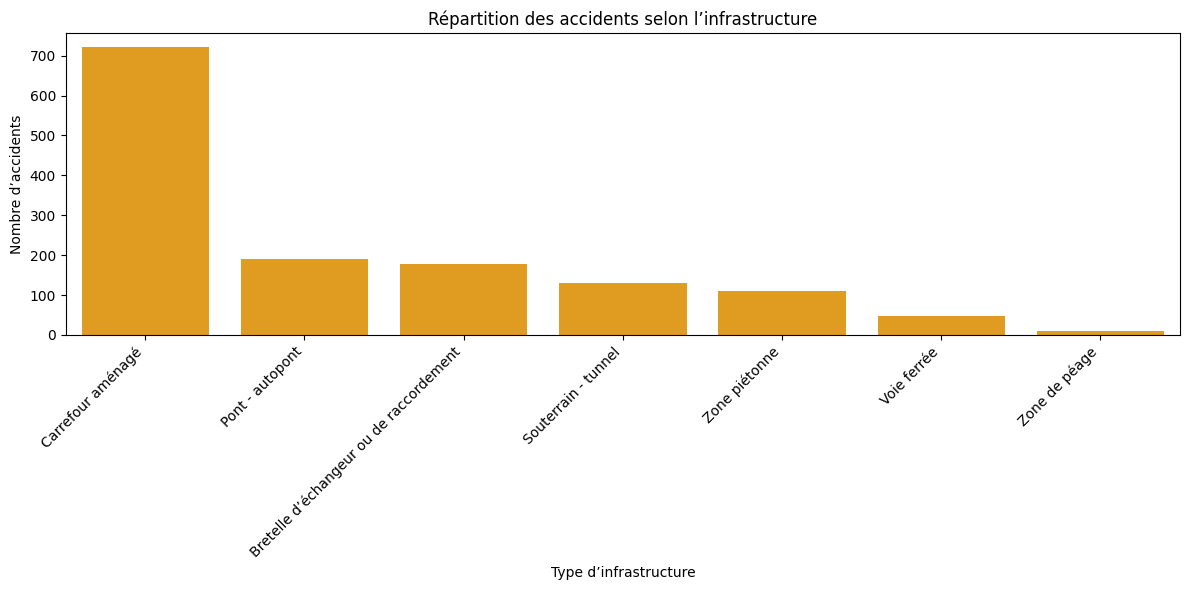

In [200]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# Connexion à la base SQLite
conn = sqlite3.connect("../accidents.db")

# Chargement des tables
df_contexte = pd.read_sql_query("SELECT * FROM dim_contexte;", conn)
df_accidents = pd.read_sql_query("SELECT * FROM fact_accidents;", conn)

# Jointure avec la table de contexte
df_full = df_accidents.merge(df_contexte, on="id_contexte", how="left")

# Vérification des colonnes présentes
print("Colonnes disponibles :", df_full.columns.tolist())

# Comptage des accidents par infrastructure
accidents_infra = (
    df_full["infrastructure"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "infrastructure", "infrastructure": "nb_accidents"})
)

# Vérification du DataFrame avant visualisation
print(accidents_infra.head())

# --- ✅ Correction importante ---
# Certaines versions de pandas inversent les noms : 
# si la colonne 'infrastructure' n'existe pas, on la corrige ici :
if "infrastructure" not in accidents_infra.columns:
    # Si les deux colonnes sont "nb_accidents" et "count" (comme ton print)
    accidents_infra.columns = ["infrastructure", "nb_accidents"]

# --- 📊 Visualisation ---
plt.figure(figsize=(12,6))
sns.barplot(
    data=accidents_infra,
    x="infrastructure",
    y="nb_accidents",
    color="orange"
)
plt.title("Répartition des accidents selon l’infrastructure")
plt.xlabel("Type d’infrastructure")
plt.ylabel("Nombre d’accidents")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [198]:
# Combien de lignes dans dim_contexte ont une valeur d'infrastructure ?
print(df_contexte['infrastructure'].value_counts(dropna=False))
print("\nNombre de lignes avec infrastructure manquante :", df_contexte['infrastructure'].isna().sum())

infrastructure
None                                       11992
Carrefour aménagé                            721
Pont - autopont                              191
Bretelle d’échangeur ou de raccordement      178
Souterrain - tunnel                          131
Zone piétonne                                110
Voie ferrée                                   47
Zone de péage                                  9
Name: count, dtype: int64

Nombre de lignes avec infrastructure manquante : 11992


✅ 13379 lignes après jointure
Colonnes disponibles : ['id_accident', 'num_acc', 'obstacle_mobile_heurte', 'obstacle_fixe_heurte', 'id_localisation', 'id_contexte', 'id_date', 'lumiere', 'intersection', 'condition_atmos', 'collision', 'type_surface', 'regime_circulation', 'voie_reservee', 'proximite_ecole', 'nombre_voie_circulation', 'categorie_route', 'pente', 'infrastructure', 'situation_accident']

✅ Colonnes dans accidents_infra : ['infrastructure', 'nb_accidents']
                            infrastructure  nb_accidents
0                            Non renseigné         11992
1                        Carrefour aménagé           721
2                          Pont - autopont           191
3  Bretelle d’échangeur ou de raccordement           178
4                      Souterrain - tunnel           131


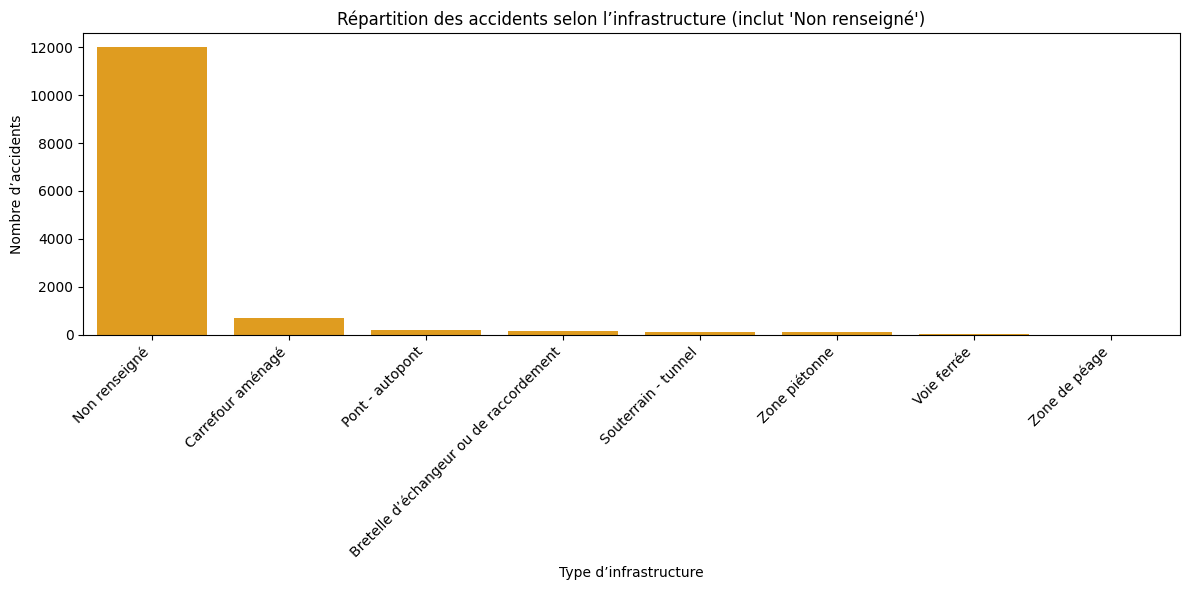

In [202]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# -----------------------------
# 🔌 Connexion à la base SQLite
# -----------------------------
conn = sqlite3.connect("../accidents.db")

# -----------------------------
# 📥 Chargement des tables
# -----------------------------
df_contexte = pd.read_sql_query("SELECT * FROM dim_contexte;", conn)
df_accidents = pd.read_sql_query("SELECT * FROM fact_accidents;", conn)

# -----------------------------
# 🔗 Jointure avec la table de contexte
# -----------------------------
df_full = df_accidents.merge(df_contexte, on="id_contexte", how="left")

print(f"✅ {len(df_full)} lignes après jointure")
print("Colonnes disponibles :", df_full.columns.tolist())

# -----------------------------
# 📊 Comptage des accidents par infrastructure
# -----------------------------
accidents_infra = (
    df_full["infrastructure"]
    .fillna("Non renseigné")  # ✅ ajoute la catégorie manquante
    .value_counts(dropna=False)
    .reset_index()
)

# Renommage explicite pour éviter l’erreur
accidents_infra.columns = ["infrastructure", "nb_accidents"]

# Tri par nombre décroissant
accidents_infra = accidents_infra.sort_values("nb_accidents", ascending=False)

# Vérification avant le graphique
print("\n✅ Colonnes dans accidents_infra :", accidents_infra.columns.tolist())
print(accidents_infra.head())

# -----------------------------
# 🎨 Visualisation
# -----------------------------
plt.figure(figsize=(12,6))
sns.barplot(
    data=accidents_infra,
    x="infrastructure",
    y="nb_accidents",
    color="orange"
)
plt.title("Répartition des accidents selon l’infrastructure (inclut 'Non renseigné')")
plt.xlabel("Type d’infrastructure")
plt.ylabel("Nombre d’accidents")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [197]:
import pandas as pd, sqlite3

conn = sqlite3.connect("../accidents.db")
df_accidents = pd.read_sql_query("SELECT * FROM fact_accidents;", conn)
df_contexte  = pd.read_sql_query("SELECT * FROM dim_contexte;",  conn)

print("— Comptages bruts —")
print("fact_accidents :", len(df_accidents))
print("dim_contexte   :", len(df_contexte))

print("\n— Nulls/uniques sur id_contexte —")
print("Nulls dans fact_accidents.id_contexte :", df_accidents['id_contexte'].isna().sum())
print("Uniques dans fact_accidents.id_contexte :", df_accidents['id_contexte'].nunique(dropna=True))
print("Uniques dans dim_contexte.id_contexte   :", df_contexte['id_contexte'].nunique(dropna=True))

df_full0 = df_accidents.merge(df_contexte, on="id_contexte", how="left")
print("\n— Après jointure brute —")
print("Lignes après merge :", len(df_full0))
print("Lignes sans contexte (infrastructure NaN) :", df_full0['infrastructure'].isna().sum())

— Comptages bruts —
fact_accidents : 13379
dim_contexte   : 13379

— Nulls/uniques sur id_contexte —
Nulls dans fact_accidents.id_contexte : 0
Uniques dans fact_accidents.id_contexte : 13379
Uniques dans dim_contexte.id_contexte   : 13379

— Après jointure brute —
Lignes après merge : 13379
Lignes sans contexte (infrastructure NaN) : 11992


In [196]:
# Valeurs de id_contexte uniques dans chaque table
set_acc = set(df_accidents["id_contexte"].dropna().unique())
set_ctx = set(df_contexte["id_contexte"].dropna().unique())

# 1. Combien sont communes
communes = set_acc & set_ctx
print(f"✅ Communes : {len(communes)} / {len(set_acc)} dans fact_accidents ({len(set_ctx)} dans dim_contexte)")

# 2. Exemples de valeurs non correspondantes
print("\n❌ Présentes dans fact_accidents mais pas dans dim_contexte :")
print(list(set_acc - set_ctx)[:10])

print("\n⚠️ Présentes dans dim_contexte mais pas dans fact_accidents :")
print(list(set_ctx - set_acc)[:10])

✅ Communes : 13379 / 13379 dans fact_accidents (13379 dans dim_contexte)

❌ Présentes dans fact_accidents mais pas dans dim_contexte :
[]

⚠️ Présentes dans dim_contexte mais pas dans fact_accidents :
[]


✅ 13379 lignes après jointure
Colonnes disponibles : ['id_accident', 'num_acc', 'obstacle_mobile_heurte', 'obstacle_fixe_heurte', 'id_localisation', 'id_contexte', 'id_date', 'lumiere', 'intersection', 'condition_atmos', 'collision', 'type_surface', 'regime_circulation', 'voie_reservee', 'proximite_ecole', 'nombre_voie_circulation', 'categorie_route', 'pente', 'infrastructure', 'situation_accident']

✅ Aperçu des données :
                                        collision  nb_accidents
0                                 Autre collision          4695
1                    Deux véhicules – par le coté          3639
2                  Deux véhicules – par l’arrière          1559
3                                  Sans collision          1464
4                       Deux véhicules - frontale          1190
5  Trois véhicules et plus - collisions multiples           418
6             Trois véhicules et plus – en chaîne           414


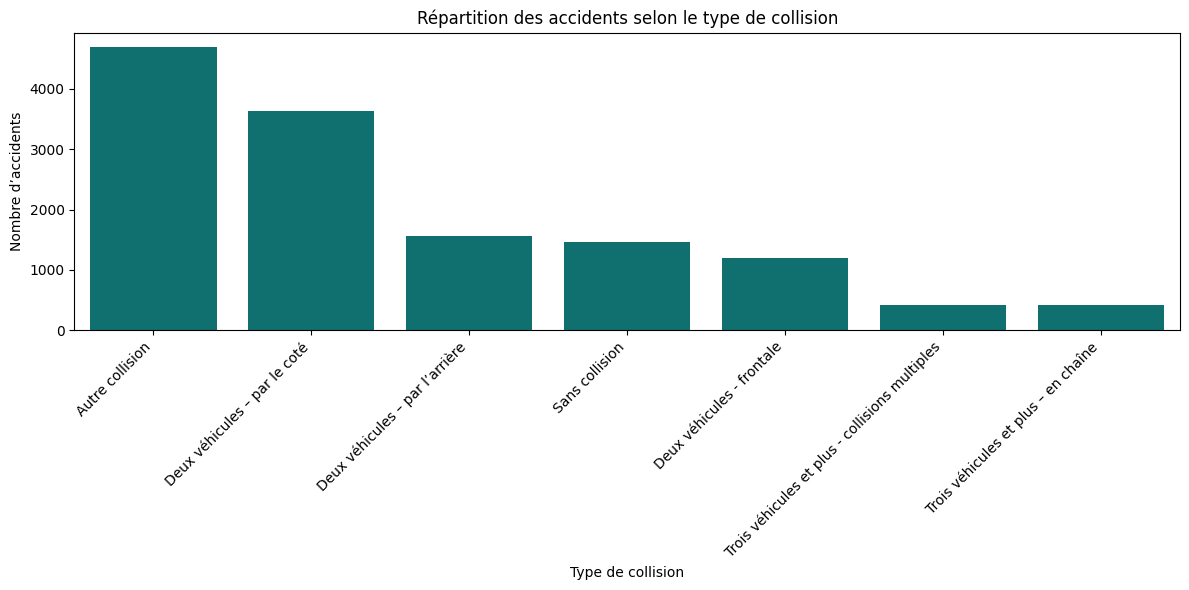

In [207]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# -----------------------------
# 🔌 Connexion à la base SQLite
# -----------------------------
conn = sqlite3.connect("../accidents.db")

# -----------------------------
# 📥 Chargement des tables
# -----------------------------
df_contexte = pd.read_sql_query("SELECT * FROM dim_contexte;", conn)
df_accidents = pd.read_sql_query("SELECT * FROM fact_accidents;", conn)

# -----------------------------
# 🔗 Jointure sur id_contexte
# -----------------------------
df_full = df_accidents.merge(df_contexte, on="id_contexte", how="left")

print(f"✅ {len(df_full)} lignes après jointure")
print("Colonnes disponibles :", df_full.columns.tolist())

# -----------------------------
# 📊 Comptage des accidents par type de collision
# -----------------------------
accidents_collision = (
    df_full["collision"]
    .fillna("Non renseigné")  # ✅ inclut les valeurs manquantes
    .value_counts(dropna=False)
    .reset_index()
)

# Renommage explicite pour éviter toute confusion
accidents_collision.columns = ["collision", "nb_accidents"]

# Tri décroissant
accidents_collision = accidents_collision.sort_values("nb_accidents", ascending=False)

# Vérification avant visualisation
print("\n✅ Aperçu des données :")
print(accidents_collision.head(10))

# -----------------------------
# 🎨 Visualisation
# -----------------------------
plt.figure(figsize=(12,6))
sns.barplot(
    data=accidents_collision,
    x="collision",
    y="nb_accidents",
    color="teal"
)
plt.title("Répartition des accidents selon le type de collision")
plt.xlabel("Type de collision")
plt.ylabel("Nombre d’accidents")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


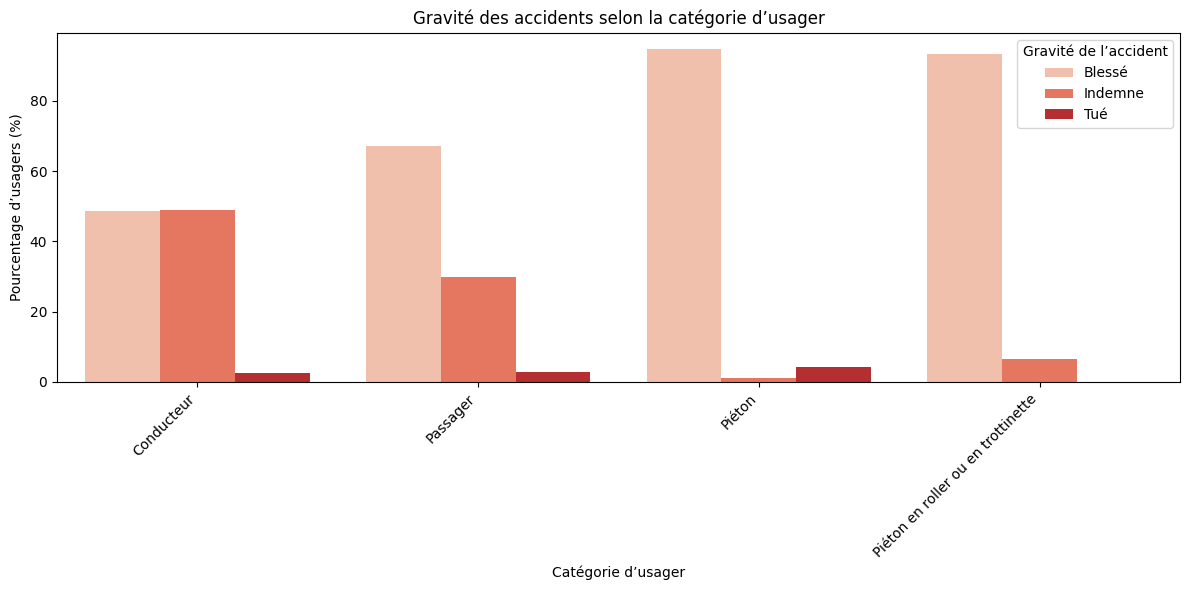

In [209]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# -----------------------------
# 🔌 Connexion à la base SQLite
# -----------------------------
conn = sqlite3.connect("../accidents.db")

# -----------------------------
# 📥 Chargement des données
# -----------------------------
df_usager = pd.read_sql_query("SELECT * FROM dim_usager;", conn)

# -----------------------------
# 🔎 Nettoyage et préparation
# -----------------------------
# Remplace les valeurs manquantes par "Non renseigné"
df_usager["gravite_accident"] = df_usager["gravite_accident"].fillna("Non renseigné")
df_usager["categorie_usager"] = df_usager["categorie_usager"].fillna("Non renseigné")

# Comptage des usagers par catégorie et gravité
gravite_par_categorie = (
    df_usager.groupby(["categorie_usager", "gravite_accident"])
    .size()
    .reset_index(name="nb_usagers")
)

# Calcul du pourcentage au sein de chaque catégorie
gravite_par_categorie["pourcentage"] = (
    gravite_par_categorie.groupby("categorie_usager")["nb_usagers"]
    .apply(lambda x: 100 * x / x.sum())
    .values
)

# -----------------------------
# 📊 Visualisation
# -----------------------------
plt.figure(figsize=(12,6))
sns.barplot(
    data=gravite_par_categorie,
    x="categorie_usager",
    y="pourcentage",
    hue="gravite_accident",
    palette="Reds"
)

plt.title("Gravité des accidents selon la catégorie d’usager")
plt.xlabel("Catégorie d’usager")
plt.ylabel("Pourcentage d’usagers (%)")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Gravité de l’accident")
plt.tight_layout()
plt.show()


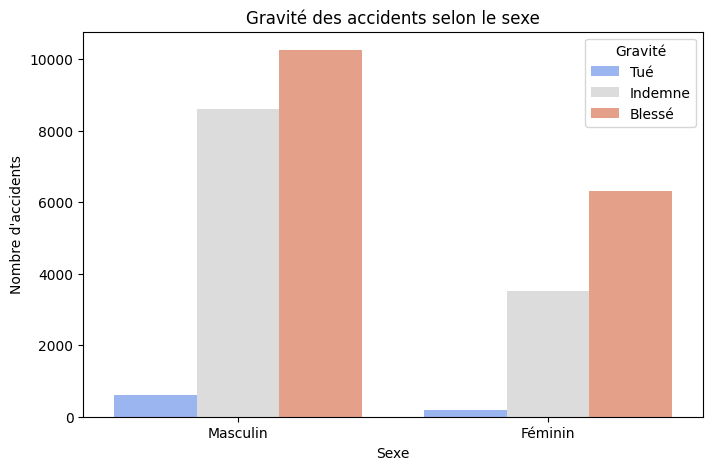

In [211]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.countplot(
    data=df_usager,
    x="sexe",
    hue="gravite_accident",
    palette="coolwarm"
)
plt.title("Gravité des accidents selon le sexe")
plt.xlabel("Sexe")
plt.ylabel("Nombre d'accidents")
plt.legend(title="Gravité")
plt.show()


         Département  Nombre_d_accidents
0              Paris                1533
1   Bouches-du-Rhône                 934
2  Seine-Saint-Denis                 611
3     Hauts-de-Seine                 567
4               None                 557
5       Val-de-Marne                 546
6              Rhône                 495
7               Nord                 407
8    Alpes-Maritimes                 380
9            Gironde                 365


/var/folders/f7/x2q7zyyn1md5k9447n0knbrc0000gn/T/ipykernel_1561/3736014655.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


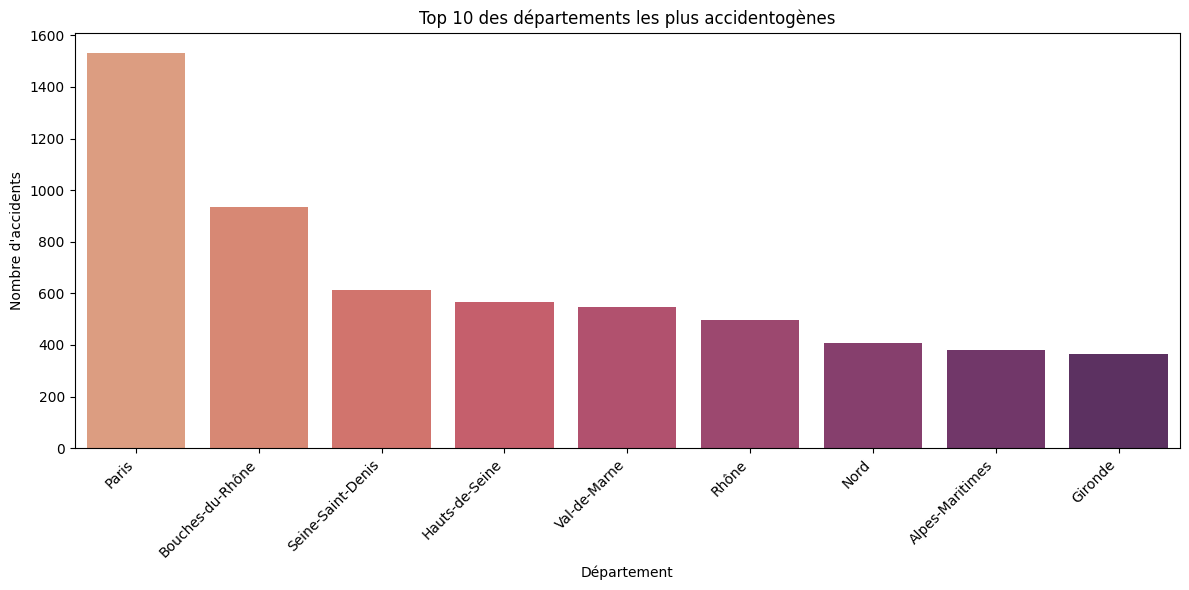

In [213]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

# -----------------------------
# 🔌 Connexion à la base SQLite
# -----------------------------
conn = sqlite3.connect("../accidents.db")

# -----------------------------
# 📥 Chargement des données
# -----------------------------
df_localisation = pd.read_sql_query("SELECT * FROM dim_localisation;", conn)
df_accidents = pd.read_sql_query("SELECT * FROM fact_accidents;", conn)

# -----------------------------
# 🔗 Jointure fact_accidents ↔ dim_localisation
# -----------------------------
df_full = df_accidents.merge(df_localisation, on="id_localisation", how="left")

# -----------------------------
# 🧮 Comptage des accidents par département
# -----------------------------
accidents_par_dept = (
    df_full["nom_departement"]
    .value_counts(dropna=False)
    .reset_index()
)

# 🏷️ Renommage explicite des colonnes
accidents_par_dept.columns = ["Département", "Nombre_d_accidents"]

# 🔝 Sélection du Top 10
top10_dept = accidents_par_dept.head(10)

print(top10_dept)

# -----------------------------
# 📊 Visualisation
# -----------------------------
plt.figure(figsize=(12,6))
sns.barplot(
    data=top10_dept,
    x="Département",
    y="Nombre_d_accidents",
    palette="flare"
)

plt.title("Top 10 des départements les plus accidentogènes")
plt.xlabel("Département")
plt.ylabel("Nombre d'accidents")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [214]:
pd.read_sql_query("SELECT COUNT(DISTINCT id_accident) FROM fact_accidents;", conn)

,COUNT(DISTINCT id_accident)
0,13379


In [215]:
query = """
SELECT d.nom_departement, COUNT(DISTINCT f.id_accident) AS nb_accidents
FROM fact_accidents f
JOIN dim_localisation d ON f.id_localisation = d.id_localisation
GROUP BY d.nom_departement
ORDER BY nb_accidents DESC
LIMIT 10;
"""
pd.read_sql_query(query, conn)

,nom_departement,nb_accidents
0,Paris,1533
1,Bouches-du-Rhône,934
2,Seine-Saint-Denis,611
3,Hauts-de-Seine,567
4,None,557
5,Val-de-Marne,546
6,Rhône,495
7,Nord,407
8,Alpes-Maritimes,380
9,Gironde,365
